---
title: "What's in a $p$-value?"
date: "`r Sys.Date()`"

author:
  - name: Frederik Aust
    orcid: 0000-0003-4900-788X
    email: frederik.aust@uni-koeln.de
    affiliations:
      - ref: uoc
      - ref: uva
  - name: Eric-Jan Wagenmakers
    orcid: 0000-0003-1596-1034
    affiliations:
      - ref: uva

affiliations:
  - id: uoc
    name: University of Cologne
    city: Cologne
    country: Germany
  - id: uva
    name: University of Amsterdam
    city: Amsterdam
    state: The Netherlands

abstract: "**TODO**"

toc: true
floatsintext: true
number-sections: true
bibliography: "bibliography.bib"
keywords: ["p-values", "evidence", "Bayes factor"]

highlight-style: github
theme: lumen

execute:
  keep-md: true
  echo: false

format:
  apaquarto-pdf:
    documentmode: man
    keep-tex: true
    # include-in-header:
    #   - text: |
    #       \usepackage{amsmath}

# reference-location: margin
# html:
#   standalone: true
#   embed-resources: true
#   self-contained: true
#   link-external-icon: true
#   citations-hover: true
#   footnotes-hover: true

jupyter:
  kernelspec:
    name: "ir43"
    language: "R"
    display_name: "R 4.3.4"
---

In [ ]:
#| label: setup
#| include: false

library("dplyr")
library("jab")
library("BayesFactor")
library("abtest")

library("ggplot2")
library("geomtextpath")
library("lemon")
library("patchwork")
library("papaja")

library("gt")

In [ ]:
#| label: other-bf-approximations
minbf <- function(p) {
  ifelse(
    p < 1/exp(1)
    , -exp(1) * p * log(p)
    , 1
  )
}

chi2_to_bicbf <- function(x, n, df = 1) {
  delta_ll <- -0.5 * x
  exp(0.5 * df * log(n) + delta_ll) |>
    as.numeric()
}

chi2p_to_bicbf <- function(x, n, df = 1) {
  chi2 <- qchisq(1-x, df = 1)
  chi2_to_bicbf(chi2, n, df)
}

t_to_bicbf <- function(t, n, samples = 1, ess = NULL, null_centered_prior = TRUE) {
  if(is.null(ess)) ess <- n
  ess <- ess + 1
  delta_ll <- n / 2 * log(1 + t^2 / (n - samples)) # Stuart & Kendal (1961, p. 225)
  delta_ll  <- delta_ll / (n / (n - null_centered_prior * samples / 2)) # Eqs. 4 and 5, Wagenmakers (2021)
  delta_bic <- -log(ess) + 2 * delta_ll
  exp(delta_bic / 2)
}


# 1/t_to_bicbf(t = 1.5, n = 20)
# jab::jab_3pn(2*(1-pt(1.5, df = 19)), 20)

to_reciprocal <- function(x) {
  ifelse(
    x >= 1
    , as.character(round(x))
    , paste0("1/", round(1/x))
  )
}

# minp <- function(bf) {
#   exp(lamW::lambertWm1(-bf / exp(1)))
# }

In [ ]:
#| label: curvatures

cnorm <- \(x, sigma) {
  (x^2 - sigma^2)/(exp(x^2/(2* sigma^2)) * sqrt(2 * pi) * sigma^5)
}

clogis <- \(x, sigma) {
  (exp(x/sigma) * (1 - 4 * exp(x/sigma) + exp((2 * x)/sigma)))/((1 + exp(x/sigma))^4 * sigma^3)
}

ccauchy <- \(x, scale) {
  (-2 * scale * (-3 * x^2 + scale^2))/(pi * (x^2 + scale^2)^3)
}

g_small_sample <- \(se, ...) {
  max(se^2 / 2 * ccauchy(...), 0)
}

Null hypothesis significance testing is ubiquitous in psychological science and beyond.
The key outcome of this statistical procedure is the $p$ value, which researchers routinely use to decide whether to reject the null hypothesis $\mathcal{H}_0$.
It is common to interpret $p$ values as a measure of statistical evidence or as the implied probability that $\mathcal{H}_0$ is true [@Gigerenzer2018; @Cohen1994].
This is despite repeated efforts to explain that the $p$ value is *not* a measure of evidence [**???**, @Hubbard2008; Royall, 1997; Goodman & Royall, 1988].
In contrast, Bayesian model comparisons do yield a principled measure of relative evidence: the Bayes factor.
However, unlike $p$ values, the Bayes factor is not routinely reported.
Fortunately for the evidence-seeking reader, $p$ values can be monotonically related to the Bayes factor [@Berger1987] and, as we will show, this relationship can be exploited to gauge the evidence implied by a reported $p$ value.
All that is needed is the effective sample size [@Wagenmakers2022].
The resulting approximate Bayes factor is a useful tool for researchers, reviewers, and readers to interpret emprical results---even under conditions that threaten frequentist inference, most notably when the data may have been peaked at.

For those that unfamiliar with the debate, the upcoming section illustrate practical problems that arise when $p$ values are interpreted as measures of evidence.
In the following two sections, we show that the Bayes factor avoids these problems because it quantifies evidence as the relative predictive accuracy of two competing hypotheses.
We highlight two additional attractive properties of the Bayes factor: Identifying weak or inconclusive evidence and the independence of researchers' sampling intentions.
Although we have doen our best to make these section engaging, busy readers familiar with the Bayes factor may wish to skip them.
We then get to the heart of our contribution:
We show how the monotonic relationship between $p$ values and the Bayes factor can be exploited in a simple formula to approximate the Bayes factor.
This approximation combines $p$ and effective sample size $n_\text{eff}$ and closely approximates the Bayes factor.
We demonstrate the closeness of the approximation by reanalyzing two large datasets of published $p$ values for tests of mean comparisons and proportions.
Finally, we discuss the implications of the approximation for the suggested evidential interpretations of $p$ values.

# $p$ as conflict or surprise

To understand why $p$ values are not a measure of evidence, it may be useful to briefly review what they are.
In the following, we will limit our discussion to one-sided $p$-values for the sake of simplicity.
The $p$ value is defined as the percentile of the observed test statistic $t$ in the distribution of all test statistics $T$ that could have been observed if the null hypothesis $\mathcal{H}_0$ were true,

$$
p = \text{Pr}(T \geq \text{abs}(t) \mid \mathcal{H}_0).
$$

In other words, the $p$ value is measure of conflict between the data and $\mathcal{H}_0$ and quantifies the information against $\mathcal{H}_0$---smaller values indicating stronger conflict [@Perezgonzalez2015; @Greenland2019].


<!-- You cannot load a coin! 10.1198/000313002605 -->

This conflict between the data and $\mathcal{H}_0$ can be expressed on a different scale: the $s$ value, where $s = -\log_2(p)$ [@Rafi2020].
The $s$ value can be thought of as a measure of *surprise* in units of bits (or Shannon-information).
To intuit the meaning of a bit of information, indulge me in a game of chance:
The rules are simple: I toss a coin; tails, you win; heads, I win.
Let's play.
In the first round, I flip the coin and it comes up heads.
I flip the coin a second time and, again, it comes up heads; the third and fourth time the coin also comes up heads.
Take a moment to imagine your surprise; hold on to that feeling.

Entering this game of chance, you hopefully assumed that the coin is fair---who would try to cheat their readers.
Based on this assumption every subsequent flip that comes up heads should increase your surprise about my run of good luck.
The $s$ value quantifies this surprise: $s = 2$ corresponds to a streak of all heads from two tosses, $s = 3$ to a streak of all heads from three tosses, and so on.
The surprise you felt after the fourth flip roughly corresponds to the surprise conveyed by $p = .05 = .5^{4.32}$ in an one-sided exact binomail test [p. 109, @Greenland2019; @Cole2020].
I flip the coin one last time and, lo and behold, it comes up heads again.

Did I get lucky?
Are you suspicious, yet?
Am I using a flipping technique that biases the coin to come up heads?
The $p$ value for this run of five heads drops to $p = `r print_p(0.5^5)` = 0.5^5$; adopting an error rate of $\alpha = .05$, which most scientific disciplines deem acceptable, the surprise, that is the conflict between data and $\mathcal{H}_0:~\theta = .5$ is strong enough to reject $\mathcal{H}_0$ and conclude foul play on my part.
But I will protest: "This is preposterous! There is no evidence for such accusations. You are jumping to conclusions!"
Well, what is the evidence?
How strongly should my run of good luck change your belief that I tossed the coin fairly?
Or, more formally, what is the posterior probability of $\mathcal{H}_0$ given the data $\mathbf{y}$, $\text{Pr}(\mathcal{H}_0 \mid \mathbf{y} = \text{{HHHHH}})$?
To answer these question, we need to think about alternatives to $\mathcal{H}_0$.

In the following section we attempt to convey an intuitve understanding of the Bayes factor and illustrate how this measure of evidence differs from the $p$ value.
This and the next section may leave some readers wanting for a more in-depth treatment---we refer them to the annotated reading list provided by @Etz2017 [also see @Allabadi2024; @Morey2016].

# Quantifying evidence

<!-- - Researchers commonly interpret $p$-values as a measure of evidence (Nickerson, 2000, pp. 246-247; recently reviewed in <@Gigerenzer2018>)
    - Evidential interpretation is recommended in text books
        - Medical statistics: Bland
        - Statistics "proper": Wasserman
        - Other examples?
    - Fisher thought of $p$ as a measure of evidence''
        - "the observed _p_-value is taken as evidence against the null hypothesis, so that the smaller the _p_-value the stronger the evidence it provides ([Fisher, 1960](https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00223/full#B18); [Spielman, 1978](https://www.frontiersin.org/articles/10.3389/fpsyg.2015.00223/full#B68))." (Perezgonzalez, 2015)
        - "Fisher's levels of significance: They do not need to be rigid (e.g., p-values such as 0.049 and 0.051 have about the same statistical significance around a convenient level of significance of 5%; Johnstone, 1987)." (Perezgonzalez, 2015; also see Cohen's "The world is round")
        - "In a Fisherian framework a _p_ value is interpreted as a continuous measure of compatibility between the observed data and the null hypothesis ([Greenland et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114329/#bibr26-1745691620958012))." (Lakens, 2021)


- p-values are not a measure of evidence
    - They rely on counterfactual data and quantify the prior probability of the data given a null hypothesis
        - Fisher was vehemently against putting forward an alternative hypothesis (Hubbard, 2004; cited from Perezgonzalez, 2015).
    - Coherent use of p-values requires Neyman-Pearson testing approach
        - Specification of alternative hypothesis (smallest effect size of interest) and power
        - Control of error rates either via power considerations or ng NHST and equivalence testing
        - No assessment of evidence; decision procedure
            - "p-values [...] under this approach [...] have no evidential properties whatsoever (Frick, 1996; Gigerenzer, 2004)." (Perezgonzalez, 2015)
            - "If the observed result falls outside the critical region and the test has low power, conclude nothing. (Ideally, you would not carry out research with low power—Neyman, 1955)." (Perezgonzalez, 2015)
            - "[Neyman and Pearson (1933)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114329/#bibr51-1745691620958012) were very clear that they did not intend to develop a method to inform us about the probability that our hypotheses are true, but that, “without hoping to know whether each separate hypothesis is true or false, we may search for rules to govern our behaviour with regard to them, in following which we insure that, in the long run of experience, we shall not be too often wrong” (p. 291)." (Lakens, 2021) -->

<!-- - Brief introduction to the Bayes factor
    - Relative prior predictive accuracy
    - Marginal likelihoods are difficult to calculate -->

Quantifying $\text{Pr}(\mathcal{H}_0)$ requires that we distribute probabilities over a finite number of hypotheses $\mathcal{H}_i$, such that $\sum_i{\text{Pr}(\mathcal{H}_i)} = 1$.
If no alternative to $\mathcal{H}_0$ exists, the posterior probability of $\mathcal{H}_0$ must be 1---regardless of the data.
If there are alternatives but they are not specified, $\text{Pr}(\mathcal{H}_0)$ is undefined---we can only quantify the surprise, i.e. the conflict between the data and $\mathcal{H}_0$.
But it remains unclear how to translate this surprise into the probability that the coin was tossed fairly.
We must specified alternative hypotheses to derive the posterior probability,

$$
\text{Pr}(\mathcal{H}_0 \mid \mathbf{y}) =  \text{Pr}(\mathcal{H}_0) \times \frac{\text{Pr}(\mathbf{y} \mid \mathcal{H}_0)}{\sum_i{\text{Pr}(\mathcal{H}_i) \times \text{Pr}(\mathbf{y} \mid \mathcal{H}_i)}}.
$$

So let's think about alternatives to fair coin tossing.
What's the probability $\theta$ of coming up heads for coin tossing tricksters?
Could I toss my coin to come up heads with a probability of $\theta = 1$ without youa noticing?
The data seem to suggest that this is the most likely alternative wiht $\hat\theta = 5/5 = 1$.
This would be outrageous (but also impressive, no?), so let's entertain this alternative hypothesis as $\mathcal{H}_1$.
Maybe I am a less skilled or more subtle trickster, flipping my coin to come up heads with a probability of $\theta = .60$, $\theta = .65$, or $\theta = .70$?
None of these exact probabilites seems to deserve special consideration.
All are plausible, some more than others; so we will specify a general alternative hypothesis and assign $\theta$ a prior distribution constraining $\theta > .5$, $\mathcal{H}_2:~2\theta-1 \sim \mathcal{B}(a = 2, b = 3)$, see @fig-coin-hypotheses.

Warning messages:
1: In is.na(x) :
  is.na() applied to non-(list or vector) of type 'language'
2: In is.na(x) :
  is.na() applied to non-(list or vector) of type 'language'
3: In is.na(x) :
  is.na() applied to non-(list or vector) of type 'language'


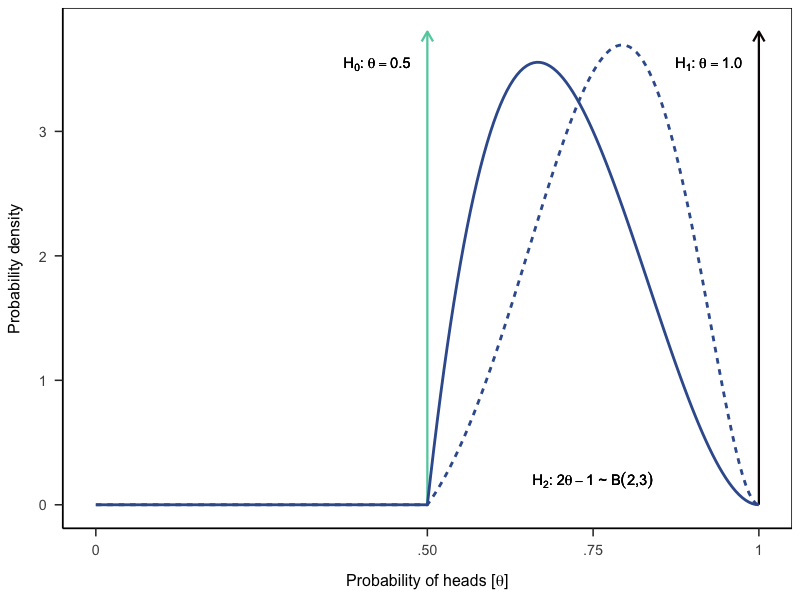

In [ ]:
#| label: fig-coin-hypotheses
#| fig-cap: Prior probability distributions for the probability of heads $\theta$ for the toss of a coin. The orange arrow represents the point hypothesis $\mathcal{H}_0$ that the coin is fair, the purple arrow represents the point hypothesis $\mathcal{H}_1$ that the coin always comes up heads, and the red curve is the continuous hypothesis $\mathcal{H}_2$ that the coin is loaded to come up heads but the probability of heads is unknown. The dashed line represents the posterior distribution of $\theta$ given $\mathcal{H}_2$ and the data $\mathbf{y} = \{HHHHH\}$.
#| warning: false
#| fig-height: 2.5

k <- 5
n <- 5
a <- 2
b <- 3
lower <- 0.5
upper <- 1

coin_col <- viridisLite::mako(3, begin = 0, end = 0.8)

dtbeta <- function(x, shape1, shape2, lower, upper) {
  dbeta((x - lower) / (upper - lower), shape1, shape2) / (upper - lower)
}

dtbeta_binom <- function(x, k, n, shape1, shape2, lb, ub) {
  dtbeta(x, shape1, shape2, lb, ub) * dbinom(k, n, x)
}
post_dtbeta <- function(x, k, n, shape1, shape2, lower, upper) {
  nc <- integrate(dtbeta_binom, lower = lower, upper = upper, k = k, n = n, shape1 = shape1, shape2 = shape2, lb = lower, ub = upper)$value
  dtbeta_binom(x, k, n, shape1, shape2, lower, upper) / nc
}

ggplot() +
  geom_segment(
    aes(
      x = 0.5, y = 0, xend = 0.5, yend = dbeta(a/(a + b), a, b) * 2.2
    )
    , linewidth = 0.8
    , arrow = arrow(length = unit(0.3, "cm"))
    , color = coin_col[3]
  ) +
  annotate(
    geom = "text"
    , x = 0.5 - 0.025
    , y = dbeta(a/(a + b), a, b) * 2.05
    , label = bquote("H"[0]*":"~theta == 0.5)
    , hjust = 1
  ) +
  geom_segment(
    aes(x = 1, y = 0, xend = 1, yend = dbeta(a/(a + b), a, b) * 2.2)
    , linewidth = 0.8
    , arrow = arrow(length = unit(0.3, "cm"))
    , color = coin_col[1]
  ) +
  annotate(
    geom = "text"
    , x = 1 - 0.025
    , y = dbeta(a/(a + b), a, b) * 2.05
    , label = bquote("H"[1]*":"~theta == "1.0")
    , hjust = 1
  ) +
  stat_function(
    fun = dtbeta
    , args = list(shape1 = a, shape2 = b, lower = 0.5, upper = 1)
    , linewidth = 1
    , n = 201
    , color = coin_col[2]
    , xlim = c(0, 1)
  ) +
  annotate(
    geom = "text"
    , x = 0.75
    , y = 0 + 0.2
    , label = bquote("H"[2]*":"~2*theta-1*" ~ B"*(.(a)*","*.(b)))
  ) +
  stat_function(
    fun = post_dtbeta
    , args = list(k = k, n = n, shape1 = a, shape2 = b, lower = 0.5, upper = 1)
    , linewidth = 1
    , linetype = "22"
    , n = 201
    , color = coin_col[2]
    , xlim = c(0, 1)
  ) +
  # annotate(
  #   geom = "text"
  #   , x = 0.775
  #   , y = 0 + 0.7
  #   , label = bquote("Pr"*(theta~"|"~"k, n, "*"H"[2]))
  # ) +
  scale_x_continuous(
    breaks = c(0, 0.5, 0.75, 1)
    , labels = c("0", ".50", ".75", "1")
  ) +
  labs(
    x = bquote("Probability of heads ["*theta*"]")
    , y = "Probability density"
  ) +
  coord_cartesian(xlim = c(0, 1)) +
  papaja::theme_apa(box = TRUE)

Deriving the posterior probability of $\mathcal{H}_0$ directly is conceptually inconvenient.
Reasonable people will disagree what all relevant alternatives are and how likely they are a priori.
It is more convenient to think about the odds of pairs of hypotheses and the relative evidence in the data, i.e. the Bayes factor (BF) $\text{BF}_{01}$:

$$
\underbrace{ \frac{p(\mathcal{H}_0  \mid \mathbf{y})}{p(\mathcal{H}_1  \mid \mathbf{y})}}_{\substack{\text{Posterior beliefs}\\ \text{about hypotheses}} } \,\, =
\underbrace{ \frac{p(\mathcal{H}_0)}{p(\mathcal{H}_1)}}_{\substack{\text{Prior beliefs}\\ \text{about hypotheses}} }
\times \,\,\,\,\,
\underbrace{ \frac{p(\mathbf{y} \mid \mathcal{H}_0)}{p(\mathbf{y} \mid  \mathcal{H}_1)}}_{\substack{\text{Bayes factor BF}_{01}\\(\text{relative evidence}) } }.
$$

On the odds scale, we can limit our considerations to two relevnt hypotheses and it allows us to separate the prior beliefs from the evidence in the data.
Now it becomes clear that according to Bayes theorem, evidence is defined as the relative predictive accuracy of two hypotheses.
The evidence quantifies how much better one hypothesis predicts the data than another, or with under which hypothesis the data are less surprising.


So, what's the evidence that I cheated you?
As noted above, a run of five heads corresponds to a $p = .031 = 0.5^5$ and $s = 5$ assuming $\mathcal{H}_0$ is true and $\theta = .5$.
Conveniently, I constructed this example such that $\Pr(\mathbf{y} \mid \mathcal{H}_i) = \theta^5 = p$---this is usually not the case.
This means that if $\mathcal{H}_1$ is true and $\theta = 1$, $\Pr(\mathbf{y} \mid \mathcal{H}_1) = 1$.
Hence, assuming that if I cheat it is literally *impossible* for the coin to come up tails, the data are strong evidence that I cheated you, $\text{BF}_{10} = 1/p = 1/.031 = 32$, @tbl-evidence-categories.

In [ ]:
p4 <- binom.test(4, 5, alternative = "greater")$p.value
p4_print <- papaja::print_p(p4)

Attentive readers may now point out that, counter to our initial claims, $p = 1/\text{BF}_{10} = \text{BF}_{01}$ *is* a measure of evidence against $\mathcal{H}_0$---if we assume that $\mathcal{H}_1$ is the relavant alternative hypothesis.
But this is a unlikely coincidence and immediately problems loom large.
Most obviously, $\mathcal{H}_1$ is an extreme and probably irrelevant alternative hypothesis.
I feel honored if you think otherwise, but I'm just not a skilled enough trickster.
But this evidential interpretation of $p$ sufferes from a more serious problem.
Let's briefly continue to entertain $\mathcal{H}_1$ and imagine the outcome of my fifth flip had been tails---not heads.
Now $\Pr(\mathbf{y} \mid \mathcal{H}_0) = p = `r p4_print`$ and $s = `r round(-log2(p4), 2)`$, so we should be less surprised---roughly equivalent to the surprise of 2 heads out of 2 tosses.
But when we take our alternative hypothesis into account, we see a stark difference between $p$ and the Bayes factor: $\Pr(\mathbf{y} \mid \mathcal{H}_1) = 0$ and hence $\text{BF}_{01} = `r p4_print`/0 = \infty$.
Take a moment to reflect what this means:
The $p$ value proclaims some conflict between the data and $\mathcal{H}_0$, but the real story here is that $\mathcal{H}_1$ has been conclusively ruled out.
The evidential interpretation of $p$ could hardly be more misleading.

<!-- We cannot corroborate!
But this is not a relative measure and the alternative hypothesis to the fair coin remains unspecified and thereby implicit.
This measure is not consistent in that it will not select a true H_0 in an infinitely large sample because the the random variable $P$ is uniformly distributed on $[0, 1]$ under $\mathcal{H}_0$.
It can only quantify information at odds with $\mathcal{H}_0$. -->

The evidential interpretation of $p$ misleads us because $p$ does not take any alternative hypotheses into account.
Consider another possible outcome of my coin flips to see appreciate that $p$ can never corroborate $\mathcal{H}_0$.
Imagine my coin had come up tails---not heads---five times in a row.
Now $\Pr(\mathbf{y} \mid \mathcal{H}_0) = p = 1$ and $s = 0$.
Again, appreciate what this means.
The data could not be more compatible with $\mathcal{H}_0$ (remember, we assume I am a self-serving cheater and $\theta > .5$, i.e. the test is one-tailed).
The $p$ value can only indicates that we should not be surprised.
In fact, as the $s$ value highlights, it is like having observed no data at all!

In [ ]:
#| label: coin-bfs
#| include: false

pyh2 <- integrate(dtbeta_binom, lower = lower, upper = upper, k = 5, n = 5, shape1 = 2, shape2 = 3, lb = lower, ub = upper)$value

bf02 <- round(0.5^5 / pyh2, 3)
pyh2 <- round(pyh2, 3)

pyh2_0 <- integrate(dtbeta_binom, lower = lower, upper = upper, k = 0, n = 5, shape1 = 2, shape2 = 3, lb = lower, ub = upper)$value

bf02_0 <- round(0.5^0 / pyh2_0, 2) 
pyh2_0 <- round(pyh2_0, 3)

But on to the burning question: What is the evidence I cheated assuming that my skills to bias the coin are more modest, $\mathcal{H}_2$.
The data provide moderate evidence that my flipping is biased to come up heads, $\text{BF}_{02} = 0.5^5 / `r pyh2` = `r bf02`$.
The evidence is weaker than for $\mathcal{H}_1$ because the predictions of $\mathcal{H}_2$ are less extreme and more similar to those of $\mathcal{H}_0$.
Whether you think this evidence is enough to accuse me of foul play depends on your prior beliefs about $\mathcal{H}_0$ and $\mathcal{H}_2$ of course.
I have a strong prior belief in my own honesty---there is considerable empricial evidence for my unbiased coin flipping technique [Table 1 in 
@Bartos2024]!
But I won't hold it against you if you suspect otherwise.
Before you convict me, however, remember that your prior probability may be tainted by the fact that we've already seen the data.
Did you suspect I would cheat you when opening this article?
Unless you are a paragon of virtue or a perfectly rational robot capable of compartmentalizing information, it's wise to approach this task conservatively.
Pretending we haven't seen what we've seen is about as easy as un-ringing a bell.

We will discuss how to derive an approximate Bayes factor from $p$, shortly, but let's first examine the Bayes factor if we again imagine my coin had come up tails---not heads---five times in a row.
As we have seen $p = 1$ and $s = 0$---no surprise, no information.
The Bayes factor, on the other hand, indicates strong evidence in favor of the coin being fair, $\text{BF}_{02} = 0.5^5 / `r pyh2_0` = `r bf02_0`$.
A judge who relies on $p$ as a measure of evidence risks ignoring evidence to the contrary[^npt]; a judge who considers the Bayes factor stands a chance to uphold the principles of Justitia.
Or in the words of @Jeffreys1961,

> The most serious drawback [...] is the deliberate omission to give any meaning to the probability of a hypothesis. All that they can do is to set up a hypothesis and give arbitrary rules for rejecting it in certain circumstances. They do not say what hypothesis should replace it in the event of rejection [...] It is merely something set up like a coconut to stand until it is hit [...] (p. 377)

[^npt]: Those, uninterested in evidence, may use $p$ in a Neyman-Pearson decision procedure to reject $\mathcal{H}_0$ when $p \leq \alpha$ and will be wrong at a rate of $\alpha$ in the long run.
Such a decision procedure can reject $\mathcal{H}_1$ on the basis of $p > \alpha$ only if the study and decision procedure has a known and low enough long-run risk of such decisions being incorrect, $\beta$ [@Greenland2019].
Yet none of these additional steps warrant an evidential interpretation of $p$.

<!-- NP-Testing:
$p$ values are defined in relation to a theoretical distribution of counterfactual data $T$ that could have been observed under $\mathcal{H}_0$.
Therefore $p$ is a theoretical long-run probability conditional on $\mathcal{H}_0$ being true.

> In the decision-theoretical (Neyman– Pearsonian) definition, the observed p is often defined as the smallest α level (testing cutoff) that would allow rejection in an α-level decision rule (Neyman–Pearson hypothesis test) which rejects H when p ≤ α (e.g., Lehmann 1986). 

In NP, $p$ is considered a realization of a random variable $P$ resulting from counterfactually repeated experiments.
If $\mathcal{H}_0$ were true, $P$ is uniformly distributed on $[0, 1]$ and the decision to reject $\mathcal{H}_0$ when $p \leq \alpha$ is associated the long-run risk $\alpha$ of being incorrect. -->

# Desirable properties of the Bayes factor {#sec-desirable-properties}

As noted above, psychological researchers commonly interpret $p$ values as a measure of statistical evidence or as the implied probability that a statistical hypothesis is true [@Gigerenzer2018; @Cohen1994].
For this reason alone the Bayes factor is a desirable alternative to the $p$ value.
But the Bayes factor has other desirable properties that make it a useful tool for researchers, reviewers, and readers of the scientific literature.
Consider the following two properties:
The Bayes factor clearly indicates when the data provide weak or inconclusive evidence, and is independet of researchers' sampling intentions.

As demonstrated, the Bayes factor is a contiuous measure of relative evidence.
It can indicate whether the data support $\mathcal{H}_1$ or $\mathcal{H}_0$.
However sometimes the data provide little or no evidence either way.
Recognizing inconclusive results is crucial; <!-- data provide weak or inconclusive evidence. -->
it should prompt researchers to avoid strong claims, collect more data, design a more informative study, or to consider other hypotheses.
The Bayes factor clearly indicates when this is the case:
When the data are equally likely under $\mathcal{H}_0$ and $\mathcal{H}_1$, the Bayes factor is 1.
In contrast, a large, non-significant p-value from null hypothesis significance testing (NHST) is often difficult to interpret.
It indicates that the data are relatively unsurprising under $\mathcal{H}_0$---the hypothesis should not be rejected.
But on its own $p$ can never tell us if should be accepted $\mathcal{H}_0$ is true[^npt].
To make this determination, researchers should additionally must consider the $p$ for an interval nullhypothesis, such as $H_0:~.4 \geq \theta \leq .6$ [equivalence test; pp. 292--302, @Lakens2022][^beta].
If both $p > \alpha$, the data are insufficiently surprising under both hypotheses to warrant rejecting either one---the results are inconclusive.
It is ecouraging that reporting Bayes factors or equivalence tests is becoming more common, but the majority of papers still report neither.
It can therefore be difficult for reviewers and readers to evaluate which claims receive support from the data and which claims mostly reflect researchers' prior convictions.
A method to approximate Bayes factor from NHST-$p$ values should be a useful for anyone evaluating claims from empirical research, including reviewers and readers alike.

[^beta]: In a Neyman-Person testing procedure, a non-significant $p$ value may prompt the acceptance of $\mathcal{H}_0$, only if the design of the study set the probability of falsely accepting $\beta$ at a level that is deemed acceptable.
More often than not $\beta$ is unknown even for key hypothesis tests to reviewers and readers---or the researchers themselves.

In [ ]:
#| label: coin-tossing-rate
coin_tossing_time <-
  8.5 + 6.5 + 56 + 51 + 54.5 + 51 + 55 + 54.5 + 49.5 + 48.5 + 56.5 + 62

coin_tosses <- 10500

coin_tossing_rate <- (10500 / coin_tossing_time) |>
  round()

In [ ]:
#| label: sim-fixed-duration

I <- 5e5

fixed_duration <- replicate(
  I
  , rpois(1, 5) |>
    rbinom(1, 0.5) |>
    mean()
)

fixed_duration_p <- mean(fixed_duration == 1, na.rm = TRUE)

To appreciate the relevance of reasearchers' sampling intentions, let us once more return to our game of chance.
You accused me of cheating after a run of 5 heads as I explained that this corresponds to $p = 0.5^5 = `r print_p(0.5^5)`$.
But maybe *I* was the one jumping to conclusions afterall: I assumed a $\mathcal{H}_0$ that treats the number of heads as a binomial random variable $K \sim \text{Bin}(n = 5, \theta = .5)$.
Notice here that this $\mathcal{H}_0$ actually has two parameters---$n$ and $\theta$---and that both parameters are assumed to be fix to specific values.
I think we agree on the assumption that $\theta = .5$; it is a statement about my character that you want to test.
That $n = 5$, on the other hand, is an assumption I made about the data collection procedure: Every dataset you could have observed consists of exactly $n = 5$ coin flips.
In other words, $p = 0.5^5 = `r print_p(0.5^5)`$ only if one of us had decided that we would see exactly $n = 5$ flips.
In fact, my intention was to flip my coin until my thumb hurts, but at least 10.000 times.
You surely are a busy reader, so maybe you figured that you could spare no more than 30 seconds.
In this case $n$ is a random variable [Chapter 11, @Kruschke2014].
I can toss coins at a rate of $\lambda = `r round(coin_tossing_rate)`$ tosses per minute [@Bartos2024], but in a tutorial setting it would be closer to $\lambda = 10$.
So unbeknowst to me, the data were collected not with the intention that $n = 5$, but $N \sim \text{Pois}(\lambda = 5)$[^pois].
In this case, the probabilitiy of observing a run of all heads in our game is $p = `r print_p(fixed_duration_p)`$[^durationp].
But, here I go again: I'm assuming.
Maybe the time you are willing to spare is itself a random variable.
Or maybe your sampling intentions change in light of your observations: After seeing 4 out of 4 heads you decided to keep watching to see if my run of good luck continues.
I can never know.

[^pois]: The Poisson distribution is probably a bad model for the number of coin flips in a fixed amount of time, but it is a simple and illustrative example.

[^durationp]: In the absence of a well defined sampling distribution, the $p$ value can be obtained by simulating the relevant statistic---the relative frequency of heads----under $\mathcal{H}_0$ and calculating the percentile of the observed outcome. Here, we first sample a sample size from a Poisson distribution and then simulate the number of heads in this sample size from a binomial distribution.

We hope that this example illustrates how problematic it is for a measure of evidence to depend on researchers' sampling intentions.
$p$ is defined in reference to an imagined set of infinite replications of the data collection precedure.
Hence, this procedure must be known to calculate $p$.
Most NHST procdures assume fixed-$n$ designs, but researchers sampling intentions are often more complicated, sometimes subject to change, and are often unclear to reviewers and readers.
The Bayes factor quantifies the relative evidence only in the data at hand and, therefore, requires no assumptions about researchers' intentions (*likelihood principle*, **???**).
Bayes factors are readily interpretable even when researchers stopped collecting data because $p < \alpha$---a practice well known to inflate the risk of incorrectly rejecting $\mathcal{H}_0$.
Hence, we believe a method to approximate the Bayes factor from NHST-$p$ values should be useful to everyone involved: researchers, reviewers and readers of the scientific literature.


<!-- - Judging from the common evidential interpretation, researchers seem to want a measure of evidence
-  Principled/Ideological reasons to prefer evidence
    - Interested in evidence rather than decision procedure
        - "[Rozeboom (1960)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114329/#bibr59-1745691620958012) criticized the use of NHST because “the primary aim of a scientific experiment is not to precipitate decisions, but to make an appropriate adjustment in the degree to which one accepts, or believes, the hypothesis or hypotheses being tested.” (p. 420). If this is your philosophy, then a _p_ value is unlikely to provide the answer you are looking for, and you might prefer to draw nondichotomous inferences using a likelihood ratio, Bayes factor, or a Fisherian interpretation of _p_ values." (Lakens, 2021)
    - Derive probability that a hypothesis is true
      - " As seen above, Berger and his colleagues had already shown the p value to be a poor gauge of evidence in a Bayesian context. They now wanted to determine if p values are useful measures of evidence against H0 when considered from a Neyman–Pearsonian perspective. Accordingly, Sellke et al. (2001) devised a method for ‘calibrating’ p values so that they can be interpreted as Neyman–Pearson frequentist error probabilities. The end result of this calibration is as follows: α(p) = (1 + [– e p log(p)]−1)−1. Consequently, p = .05 translates into frequentist error probability α (.05) = .289 in rejecting H0—a result suggesting no evidence against H0. Even α (.01) = .111. These findings convey in a non-Bayesian manner the severe problems involved in using p values as credible measures of evidence against the null hypothesis." (Hubbard & Lindsay, 2008)
- Practical reasons to prefer evidence
    - A measure of relative evidence helps to distinguish between evidence of absence and absence of evidence
        - Without additional information a non-significant p-value is difficult to interpret
            - Power: very often not available because power differs for every test in a paper and power is typically only reported for one test, hopefully focal one
            - Equivalence tests: May not be readily available and concept of practical equivalence is difficult to apply (Check out Laken's work on this)
                - Lakens, D. (2022). Improving Your Statistical Inferences. Retrieved from https://lakens.github.io/statistical_inferences/. https://doi.org/@Lakens2022 (pp. 292--302)
        - Bayesian evidence follows the likelihood principle and does not condition on the sampling procedure, i.e. is interpretable when the data have been peaked at
            - Tool for reviewers/readers -->

<!-- ### Challenges with evidence

- Readers/Reviewers
    - Data may not be available for reanalysis
    - Reanalyses are time consuming and cumbersome -->


# Jeffreys's Approximate Bayes Factor (JAB)

In the previous sections we discussed the conceptual and practical problems that arise when interpreting $p$ values as a measure of evidence.
We introduced the Bayes factor as an alternative, showed that it overcomes the problems of the $p$ value, and highlighted some of its desirable properties.
<!-- As noted above, $p$ values continue to be ubiquitously reported in psychological research. -->
Against this backdrop, it may be unexpected that the surprise quantified by the fixed-$n$-$p$ value can be used to calculate a remarkably good approximation to the Bayes factors.
We briefly explain and illustrate this approximation, known as jeffreys's Approximate Bayes factor (JAB) and then explore it's implications for an evidential interpretation of the $p$ value.

<!-- - There is a monotonic relationship between $p$ and $p(H_0 | D)$ (Berger & Selke, 1987)
    - $p$, however, is typically smaller than $p(H_0 | D)$ (but this depends on the sample size, as we will show!) (Berger & Selke, 1987; Lindley, 1993, p. 25)
- We will show that this monotonic relationship can exploited and $p$-values be used in a surprisingly good approximation of Bayesian evidence -->

@Berger1987 showed that there is a monotonic relationship between $p$ and the Bayes factor or $\text{Pr}(\mathcal{H}_0 \mid \mathbf{y})$. 
For a given sample size, larger effects yield smaller $p$ values and stronger evidence against $\mathcal{H}_0$.
@Marsman2016 show that, for location parameters $\mu$ in the exponential family (e.g., a normal distribution) and a given sample size $n$, the logarithms of the one-sided $p$ value and the Bayes factor are approximately linearly related.
We illustrate this relationship in @fig-jab-jzs for the published $t$-test collected by Aczel et al. (2018) and Wetzels et al. (2011; previously reanalyzed by Rouder et al., 2012).
Triangles show the linear relationsip between the one-sided $p$ value and the commonly used JZS-Bayes factors (**???**) on logarithmic scales.
Note that the these $t$-test results are based on studies with varying sample size $n$.
Two things are worth noting:
(1) The logarithm of the one-sided $p$ values is substantially smaller than the Bayes factor---as a measure of evidence, it overstates the evidence against $\mathcal{H}_0$.
<!-- In fact, the one-sided $p$ value always exceeds the theoretical upper bound on the Bayes factor, as indicated by the dashed grey line---the so-called Vovk-Sellke bound (**???**). -->
(2) There is systematic variability around the best fitting line: $p$ values for large samples fall above the line, while $p$ values for small samples fall below the line.
Hence, despite being linear related to the Bayes factor, the one-sided $p$ value itself is a relatively poor approximation.
An improved approximation must reduce the bias against $\mathcal{H}_0$ and take the sample size into account.


In [ ]:
#| label: load-merge-data

jzs_scale <- 1

load("./rouder-wetzel/rouder-wetzel.RData")
rouder_wetzel_p <- dat1
aczel_p <- read.csv("./aczel/data.csv", row.names = 1) |>
  dplyr::filter(is.na(t) != TRUE & is.na(N1) != TRUE)

rouder_wetzel_p$one <- rouder_wetzel_p$one |>
  as.data.frame() |>
  dplyr::rename(
    n1 = N
    , M1 = M
    , p = dplyr::starts_with("p")
    , bf10 = dplyr::starts_with("bf")
  ) |>
  dplyr::mutate(
    n2 = NA
    , M2 = NA
    , type = "One sample"
    , se = effectsize/tvalue
  )

rouder_wetzel_p$paired <- rouder_wetzel_p$paired |>
  as.data.frame() |>
  dplyr::rename(
    n1 = N1
    , n2 = N2
    , p = dplyr::starts_with("p")
    , bf10 = dplyr::starts_with("bf")
  ) |>
  dplyr::mutate(
    n2 = NA
    , type = "Paired samples"
    , se = effectsize/tvalue
  )

rouder_wetzel_p$two <- rouder_wetzel_p$two |>
  as.data.frame() |>
  dplyr::rename(
    n1 = N1
    , n2 = N2
    , p = dplyr::starts_with("p")
    , bf10 = dplyr::starts_with("bf")
  ) |>
  dplyr::mutate(
    type = "Independent samples"
    , se = effectsize/tvalue
  )

rouder_wetzel_p_data <- rouder_wetzel_p |>
  do.call("rbind", args = _) |>
  dplyr::mutate(
    n2 = ifelse(is.na(n2), 0, n2)
    , p.calculated = 2 * pt(
      abs(tvalue)
      , ifelse(n2 == 0, n1 - 1, n1 + n2 - 2)
      , lower = FALSE
    )
    , one.tailed = ifelse(0.01 + p.calculated / 2 < p, 0, 1)
    , p = p * (1 + 1 * one.tailed)
  ) |>
  dplyr::filter(p >= .001)

aczel_p_data <- aczel_p |>
  dplyr::rename(n1 = N1) |>
  dplyr::mutate(
    tvalue = as.numeric(as.character(t))
    , p = as.numeric(as.character(p))
    , type = dplyr::case_when(
      grepl("One Sample", Type.of.statistics) ~ "One sample"
      , grepl("Paired Sample", Type.of.statistics) ~ "Paired samples"
      , .default = "Independent samples"
    )
    , n2 = ifelse(is.na(N2), 0, N2)
    , p.calculated = 2 * pt(
      abs(tvalue)
      , ifelse(n2 == 0, n1 - 1, n1 + n2 - 2)
      , lower = FALSE
    )
    , one.tailed = ifelse(0.01 + p.calculated / 2 < p, 0, 1)
    , p = p * (1 + 1 * one.tailed)
  )

p_data <- rbind(
  dplyr::select(rouder_wetzel_p_data, type, n1, n2, tvalue, p)
  , dplyr::select(aczel_p_data, type, n1, n2, tvalue, p)
) |>
  dplyr::rowwise() |>
  dplyr::mutate(
    neff = jab::ess(n1, n2)
    , se = 1 / sqrt(neff)
    , effectsize = tvalue * se
    , pos = pt(
      abs(tvalue)
      , ifelse(n2 == 0, n1 - 1, n1 + n2 - 2)
      , lower = FALSE
    )
    , p = 2 * pos
    # W-correction for using unbiased estimates of sample variance, rather than MLE
    , mle_correction = (n1 + n2) / (n1 - 1 + (n2 - 1) * (n2 > 0))
    # A for zero-centered standard Cauchy prior
    , a_std_cauchy = sqrt(pi/2) * (1 + effectsize^2)
    , llr = ((n1 + n2) / 2 * log(1 + tvalue^2 / (n1 - 1 + (n2 - 1) * (n2 > 0))))
    , bicbf = t_to_bicbf(
      tvalue
      , n = n1 + n2
      , sample = 1 + (n2 > 0)
      , ess = if(n2 == 0) NULL else neff # mean(c(n1, n2))
      # , null_centered_prior = FALSE
    )
    , jab_3pn = jab::jab_3pn(p, neff)
    , jab_pnpi = jab:::jab_pnpi(p, neff) * a_std_cauchy
    , jab_pnpi_cor = jab:::jab_pnpi(p, neff) * mle_correction * 
      a_std_cauchy
    # , jab = jab:::.jab01_w_a_n( # Identical to full form (below)
    #   w = qchisq(1 - p, df = 1)
    #   , a = a_std_cauchy
    #   , n = neff
    # )
    , jab = jab:::.jab01(
      w = qchisq(1 - p, df = 1)
      , g = dcauchy(effectsize, scale = jzs_scale)
      , se = se
    )
    , jab_ss = jab:::.jab01(
      w = qchisq(1 - p, df = 1)
      , g = dcauchy(effectsize, scale = jzs_scale) + g_small_sample(effectsize, scale = jzs_scale, se = se)
      , se = se
    )
    # , jab_cor = jab:::.jab01_w_a_n(
    #   w = qchisq(1 - p, df = 1) * mle_correction
    #   , a = a_std_cauchy
    #   , n = neff
    # )
    , jab_cor = jab:::.jab01(
      w = qchisq(1 - p, df = 1) * mle_correction
      , g = dcauchy(effectsize, scale = jzs_scale)
      , se = se
    )
    , jab_cor_ss = jab:::.jab01(
      w = qchisq(1 - p, df = 1) * mle_correction
      , g = dcauchy(effectsize, scale = jzs_scale) + g_small_sample(effectsize, scale = jzs_scale, se = se)
      , se = se
    )
    # , jab_t = jab:::.jab01_w_a_n(
    #   w = tvalue^2 / mle_correction
    #   , a = a_std_cauchy
    #   , n = neff
    # )
    , jab_llr = jab:::.jab01(
      w = 2 * llr
      , g = dcauchy(effectsize, scale = jzs_scale)
      , se = se
    )
    , jab_llr_ss = jab:::.jab01(
      w = 2 * llr
      , g = dcauchy(effectsize, scale = jzs_scale) + g_small_sample(effectsize, scale = jzs_scale, se = se)
      , se = se
    )
    # , jab_cor = jab_llr
    # , jab = jab_llr # Excellent
    # , jab = jab_llr_ss # Further improvement especially for one-sample t-tests
    # , jab = jab_cor # Almost as good!
    # , jab = jab_cor_ss # About half way between llr and cor
    # , jab = jab_pnpi_cor # Almost as good!
    , bf10 = exp(
      ttest.tstat(
        t = tvalue
        , n1 = n1
        , n2 = n2
        , nullInterval = NULL
        , rscale = jzs_scale
        , complement = FALSE
        , simple = FALSE
      )[['bf']]
    )
    , bf01 = 1 / bf10
  ) |>
  dplyr::select(
    type
    , tvalue, p, pos
    , neff, n1, n2
    , bf01
    , bicbf
    , jab_3pn, jab_pnpi, jab, jab_cor, jab_llr # , jab_t
  ) |>
  dplyr::ungroup()

saveRDS(p_data, file = "./merged_p_data.rds")

In [ ]:
#| label: plot-settings

p_boundaries <- c(0.0001, 0.001, 0.01, 0.05, 0.1, 1)
bf_labels <- c("100", "30", "10", "3", "1", "1/3", "1/10", "1/30", "1/100")
bf_breaks <- sapply(c(bf_labels), \(x) eval(parse(text = x)))

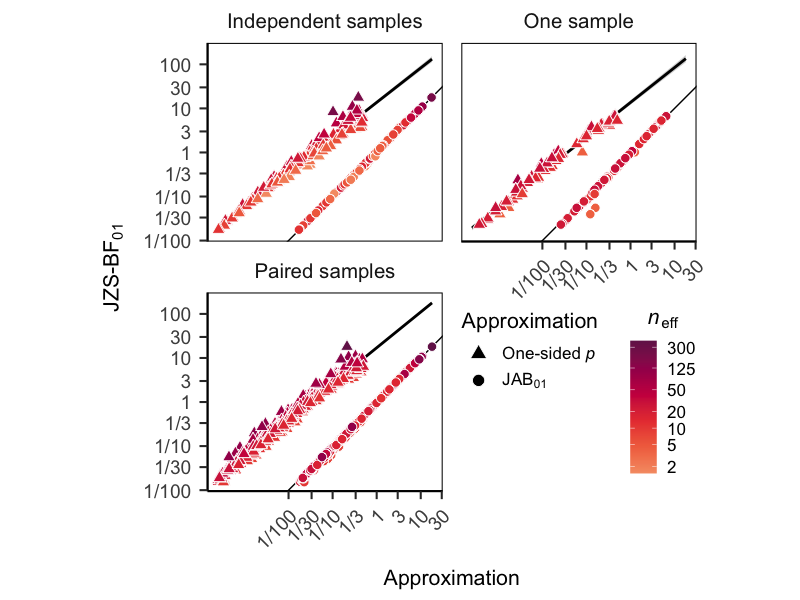

In [ ]:
#| label: fig-jab-jzs
#| fig-cap:
#|   value: glue::glue("Linear relationships between analytic JZS-Bayes factors for prior scale $r = <<round(jzs_scale, 3)>>$ and the corresponding JAB for <<nrow(p_data)>> $t$-test results collected by Aczel et al. (2018) and Wetzels et al. (2011). Triangles represent the logarithm of the one-sided $p$-values, circles represent the logarithm of $\\text{JAB}_{01}$. The color of points indicates the effective sample size. The thick solid black line shows the estimated linear relationship between the one-sided $p$ values and the JZS-Bayes factor.", .open = "<<", .close = ">>")
#|   tag: '!expr'

# jeffreys_corridor <- tibble::tibble(
#   x = c(1/100, 30)
#   , ymin = x * 3
#   , ymax = x / 3 
# )

(p_data |>
  ggplot() +
    aes(y = bf01) +
    # stat_function(aes(x = p), fun = minbf, color = grey(0.7), linetype = "22") +
    geom_smooth(aes(x = pos), formula = "y ~ x", method = "lm", fullrange = TRUE, color = "black") +
    # annotate(
    #   geom = "ribbon"
    #   , x = jeffreys_corridor$x, ymin = jeffreys_corridor$ymin, ymax = jeffreys_corridor$ymax
    #   , fill = grey(0.9)
    #   , color = NA
    #   , inherit.aes = FALSE
    # ) +
    # geom_abline(slope = 1, intercept = log(1/3), linetype = "22", color = grey(0.75)) +
    # geom_abline(slope = 1, intercept = log(3), linetype = "22", color = grey(0.75)) +
    geom_abline(slope = 1, intercept = 0) +
    geom_point(aes(x = pos, fill = neff, shape = "p"), color = "white", size = 3) +
    # geom_smooth(aes(x = p/2, color = "p"), method = "lm", fullrange = TRUE) +
    # geom_point(aes(x = p/2, fill = "p"), color = "white", shape = 21, size = 3) +
    # geom_point(aes(x = jabp, fill = "jab"), color = "white", shape = 21, size = 3) +
    # geom_point(aes(x = jab / (1/2 * sqrt(pi)), fill = N, shape = "jab"), color = "white", size = 3) +
    geom_point(aes(x = jab_cor, fill = neff, shape = "jab"), color = "white", size = 3) +
    # geom_point(aes(x = log10(jab), fill = "JAB"), color = "white", shape = 21, size = 3) +
    # geom_abline(slope = 1, intercept = -log(0.5*sqrt(pi)), linetype = "solid") +
    scale_shape_manual(values = c(21, 24), labels = c(bquote("JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE)) +
    # scale_shape_manual(values = c(21, 24), labels = c(bquote(3*italic(p)*sqrt(italic(n))*"-JAB"["01"]), bquote("One-sided"~italic(p))), name = "\nApproximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE)) +
    scale_fill_viridis_c(option = "F", begin = 0.3, end = 0.8, direction = -1, trans = "log", breaks = c(2, 5, 10, 20, 50, 125, 300), name = bquote(italic(n)["eff"])) +
    # scale_fill_viridis_d(option = "F", begin = 0.3, end = 0.8, labels = c(bquote(3*italic(p)*sqrt(italic(n))*"-JAB"["01"]), bquote(italic(p)[1])), name = "Approximation", aesthetic = c("fill", "color"), guide = guide_legend(reverse = TRUE)) +
    scale_x_continuous(
      trans = "log"
      , breaks = bf_breaks
      , labels = bf_labels
    ) +
    scale_y_continuous(
      trans = "log"
      , breaks = bf_breaks
      , labels = bf_labels
    ) +
    coord_fixed(ratio = 1) +
    labs(x = "Approximation", y = bquote("JZS-"*BF["01"])) +
    facet_wrap(~ type, ncol = 2) +
    papaja::theme_apa(base_size = 16, box = TRUE) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1)
      , legend.box = "horizontal"
      , legend.title = element_text(hjust = 0.5)
      , legend.margin = margin(0, 4, 0, 4)
    )) |>
    lemon::reposition_legend(
      position = "center"
      , panel = "panel-2-2"
    )

@Wagenmakers2022 recently highlighted that $p$ values of single-parameter Wald tests are directly related to Jeffreys's approximate Bayes factor (JAB; Jeffreys, 1936).
Jeffreys showed that an approximate Bayes factor can be obtained from the Wald statistic

$$
W = \bigg [ \frac{\hat \theta - \theta_0}{\text{SE}(\hat \theta)} \bigg ]^2
$$

for a test-relevant parameter $\theta$ and the null value $\theta_0$ as

$$
\text{JAB}_{01} = A \; \sqrt{n_\text{eff}} \; \exp(-0.5 W),
$$ {#eq-jab}

where $\sqrt{n_\text{eff}}$ is the *effective sample size* that scales the standard error (see @sec-appendix-n-eff) and $A = [\sqrt{2 \pi}~\sigma~g(\hat \theta | \mathcal{H}_1)]^{-1}$ depends on the prior distribution $g()$ evaluated at the maximum likelihood estimate of the test-relevant parameter $\hat \theta$ and residual standard deviation $\sigma$.
JAB relates to two-sided $p$-values through the quantile function $Q$ of the asymptotic sampling distributions of the corresponding Wald test statistic---the $\chi^2(\mathrm{df} = 1)$-distribution or the standard normal distribution $\mathcal{N(\mu = 0, \sigma = 1)}$,

$$
\begin{aligned}
W & = \phantom{[} Q_{\chi^2(1)}(1-p) \phantom{]^2} & \text{for } \chi^2\text{-tests and} \\
  & = [Q_{\mathcal{N(0,1)}}(p/2)]^2 & \text{for } z\text{-tests.}
\end{aligned}
$$ {#eq-w-p}

The latter is, in words, the square of the probit-transformed one-sided $p$-value.
So, JAB can be understood as a transformation of the Wald $p$-value using sample size that yields a principled measure of evidence.
In this way, JAB addresses the two short-comings of the one-sided $p$ value discussed above: It removes the bias against the null hypothesis and takes the sample size into account.
The circles in @fig-jab-jzs illustrate that the analytic JZS-Bayes factor with prior scale $r = \sqrt{2}/2$ is approximated well by corresponding JAB[^jzs-jab].
Only when the effective sample size is very small does JAB deviate noticably from the JZS-Bayes factor.
These deviations, while noticable, are small enough to be inconsequential.
In contrast to the one-sided $p$ value, JAB largely accounts for differences in evidence related to sample size.
<!-- Note that JAB indicates stronger evidence against $\mathcal{H}_0$ than the JZS-Bayes factor---the points are shifted to the left of the dashed line.
The reason for this is that the two Bayes factors follow from different prior distributions.
An exact correspondence between JAB assuming a unit-information prior and the JZS-Bayes factor is not expected. -->
<!-- In @sec-appendix-bic, we show that JAB closely correpsonds to the BIC-approximation to the Bayes factor. -->

[^jzs-jab]: Because here the $p$-values are from a $t$- rather than a Wald test, we use the analytic expression for the log likelihood ratio rather than an approximation based on $p$ itself, @sec-appendix-llr.
With an approximate likelihood ratio based on the $p$-value (@eq-w-p), JAB understates the evidence against $\mathcal{H}_0$ when effects are large and the effective sample size is small.
Note, however, that in the data used here the bias exceedes a factor of 3 only in very small samples, @sec-appendix-llr.
We believe, in most situations, the $p$-based JAB is a fair approximation to the JZS-Bayes factor for $t$-tests.

In [ ]:
#| label: analytic-proportion-bf
# Functions to calculate Bayes factors for Chi-square tests taken from
# https://github.com/fdabl/Proportion-Puzzle/blob/master/Code/helpers.R

get_bfindep_anal <- function(y1, y2, n1, n2, a = 1, b = 1) {
  post0 <- lbeta(2 * a - 1, 2 * b - 1) - 2 * lbeta(a, b)
  post1 <- (
    lbeta(2 * a + y1 + y2 - 1, 2 * b + n1 - y1 + n2 - y2 - 1) -
    lbeta(a + y1, b + n1 - y1) - lbeta(a + y2, b + n2 - y2)
  )
  
  post0 - post1
}

get_ab <- function(
  y1, y2, n1, n2, sigma_psi = 1, sigma_beta = 1, samples = 10000
  ) {
  dat <- list(y1 = y1, y2 = y2, n1 = n1, n2 = n2)

  priors <- list(
    mu_psi = 0, sigma_psi = sigma_psi,
    mu_beta = 0, sigma_beta = sigma_beta
  )
  
  abtest::ab_test(dat, prior_par = priors, nsamples = samples)
}

# Logit Transformation Bayes factor
get_bfab <- function(y1, y2, n1, n2, sigma_psi = 1, sigma_beta = 1) {
  m <- get_ab(y1, y2, n1, n2, sigma_psi = sigma_psi, sigma_beta = sigma_beta)
  m$logbf$bf10
}

In [ ]:
#| label: hoekstra-ps
#| warning: false

hoekstra <- read.csv("hoekstra/nejm.csv") |>
  dplyr::select(-P.value, -BF01) |>
  dplyr::rename(
    study = No.
    , y_1 = y1, y_2 = y2
    , n_1 = n1, n_2 = n2
  )

options(contrast = c("contr.sum", "contr.poly"))

hoekstra <- hoekstra |> 
  dplyr::rowwise() |>

  # 2 x 2-Chi-square test
  mutate(
    prop_test = prop.test(
    # prop_test = fisher.test(
      matrix(c(y_1, y_2, n_1 - y_1, n_2 - y_2), nrow = 2)
      , correct = FALSE
      # , alternative = ifelse(y_1/n_1 > y_2/n_2, "greater", "less")
    ) |>
      broom::tidy() # |>
      # dplyr::mutate(estimate = estimate2 - estimate1)
  ) |>
  dplyr::ungroup() |>

  # Logisitic regression analysis
  dplyr::mutate(
    logit_glm = hoekstra |>
      dplyr::rowwise() |>
      dplyr::do(
        as.data.frame(.) |>
        dplyr::select(study, y_1, y_2, n_1, n_2) |>
        tidyr::pivot_longer(
          cols = c("y_1", "y_2", "n_1", "n_2")
          , names_to = c("var", "group")
          , values_to = "value"
          , names_sep = "_"
        ) |>
        tidyr::pivot_wider(
          values_from = value
          , names_from = var
        ) |>
        glm(cbind(y, n-y) ~ group, family = binomial, data = _) |>
        broom::tidy() |>
        tibble::as_tibble() |>
        dplyr::filter(term == "group2") |>
        # dplyr::mutate(
        #   p.value = pnorm(abs(estimate), lower.tail = FALSE)
        # ) |>
        dplyr::select(statistic, p.value)
      )
  ) |>
  dplyr::rowwise() |>
  dplyr::mutate(
    bf01_ib = -get_bfindep_anal( # Identical to original BF01-column
      y_1, y_2
      , n_1, n_2
      , a = 1, b = 1
    ) |> exp()
    # bf01_ct = BayesFactor::contingencyTableBF( # Identical to original BF01-column
    #   matrix(c(y1, n1-y1, y2, n2-y2), nrow = 2)
    #   , sampleType = "indepMulti"
    #   , fixedMargin = "cols"
    # ) |> as.vector()
    # , bf01_ct = 1/bf01_ct
    , bf01_lt = -get_bfab(
      y_1, y_2
      , n_1, n_2
      , sigma_psi = 1
    ) |> exp()
    , prop_1 = y_1 / n_1
    , prop_2 = y_2 / n_2
    , n_prop = 1/(prop_1 * (1 - prop_1)/n_1 + prop_2 * (1 - prop_2)/n_2)
    # , jabp_prop = jab::jab_3pn(prop_test$p.value, n_prop) 
    , jabp_prop = jab:::.jab01_w_a_n(
      w = qchisq(1-prop_test$p.value, df = 1)
      # Ratio of normal prior in probit space and IB prior in probability space
      , a = dnorm(0, 0, 1) / (1 + -1 * 0)
      , n = n_prop
    )
 # / 2.4
    , bicbf_prop = chi2_to_bicbf(prop_test$statistic, n_prop)
    # , jabp_logit = jab::jab_3pn(logit_glm$p.value, n_1 + n_2)
    , n_logit = 1/(1/(y_1 + 0.5) + 1/(n_1 - y_1 + 0.5) + 1/(y_2 + 0.5) + 1/(n_2 - y_2 + 0.5))
    # , jabp_logit = jab::jab_3pn(logit_glm$p.value, n_logit)
    , jabp_logit = jab:::.jab01_w_a_n(qnorm(logit_glm$p.value/2)^2, a = 1, n = n_logit)
    , bicbf_logit = chi2_to_bicbf(logit_glm$statistic^2, n_logit)
  )

Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `prop_test = broom::tidy(...)`.
ℹ In row 25.
Caused by warning in `prop.test()`:
! Chi-squared approximation may be incorrect 


As noted above, the linear relationship between one-sided $p$ values and the Bayes factor shown in @fig-jab-jzs only holds for tests of location parameters $\mu$ in the exponential family (e.g., assuming normally distributed errors).
When the tested hypothesis is of a different kind, the close relationship between $p$ and the Bayes factor can break down.
Consider the example of comparing two independent proportions $\theta_1$ and $\theta_2$, where $\mathcal{H}_0: \theta_1 = \theta_2$.
When the number of observations is large and the probabilities not too exreme, we can test this hypothesis using a Pearson's $\chi^2$-test applied to the 2 $\times$ 2-contingency table.
Another option is to reformulate the hypothesis in terms of the odds ratio $\text{OR}$, $\mathcal{H}_0: \text{OR} = \frac{\theta_1/(1-\theta_1)}{\theta_2/(1-\theta_2)} = 1$, and test it in a logistic regression model with a binary outcome and a binary predictor using an asymptotic $z$-test.
Corresponding Bayesian hypothesis tests are available (Dablander et al., 2021).

In @fig-jab-prop, we plot the results of `r nrow(hoekstra)` published comparisons of two independent proportions collected by Hoekstra et al. (2018; reanalyzed by Dablander et al., 2021).
For both hypothesis tests there is no clear relationship between the one-sided $p$ value and the corresponding Bayes factors---this should not come as a surprise.
JAB, on the other hand, is closely linearly related to the corresponding Bayes factors.
<!-- For the logistic regression analysis, die JAB is closely related to the exact Bayes factor. -->
<!-- As noted above, JAB is based on Wald tests that yield a $chi^2$-distributed or, equivalently, $z$-distributed test statistic.
This assumption holds exactly in these comparisons of two proportions, which explains the close agreement with the exact Bayes factor.
**TODO: The logistic regression analysis also uses a unit information prior, i.e., N(0, 1), right?**
JAB based on Pearson's $\chi^2$-test indicates stronger evidence in favor of the null hypothesis relative to the corresponding Bayes factor for independent Beta-priors (IB) on both proportions.
As in the previous application, the reason is that the two Bayes factors reflect different prior distributions---an exact correspondence is not expected.
In @sec-appendix-bic, we show that JAB closely correpsonds to the approximate Bayes factor based on the Baysian Information Criterion (BIC), which assumes a unit-information pseudo-prior that is similar to JAB's proper unit-information prior. -->

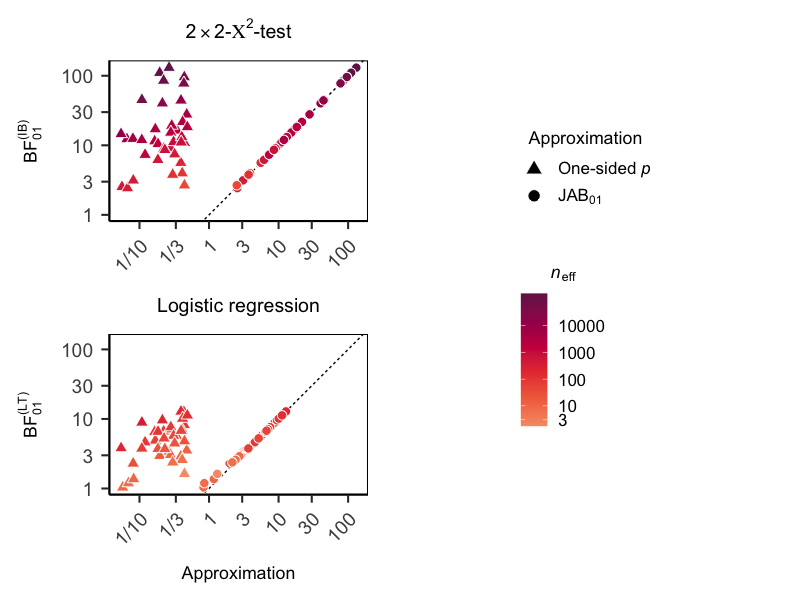

In [ ]:
#| label: fig-jab-prop
#| fig-cap:
#|   value: glue::glue("Linear relationships between Bayes factors for point null hypotheses and $p$-value-based approximations for <<nrow(hoekstra)>> results of tests comparing two proportions collected by Hoekstra et al. (2018; reanalyzed by Dablander et al., 2021). The top panel compares the results of Pearson's $\\chi^2$-test to it's Bayesian analog using independent Beta-priors (IB); the bottom panel compares the results from a logistic regression analysis to its Bayesian analog (LT). Triangles represent the logarithm of the one-sided $p$-values, circles represent the logarithm of $3 p \\sqrt{n}$-JAB. The color of points indicates the effective sample size.", .open = "<<", .close = ">>")
#|   tag: '!expr'

ib_plot <- ggplot(hoekstra) +
  aes(y = bf01_ib) +
  geom_abline(slope = 1, intercept = 0, linetype = "22") +
  geom_point(aes(x = jabp_prop, shape = "JAB", fill = n_prop), color = "white", size = 3) +
  geom_point(aes(x = prop_test$p.value/2, shape = "p", fill = n_prop), color = "white", size = 3) +
  # scale_shape_manual(values = c(21, 24), labels = c(bquote(3*italic(p)*sqrt(italic(n))*"-JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE, direction = "horizontal", title.position = "top", title.hjust = 0.5, order = 1)) +
  # scale_fill_viridis_c(option = "F", begin = 0.3, end = 0.8, direction = -1, trans = "log", breaks = c(3, 7, 20, 50, 150), name = "n", guide = guide_colorbar(title.position = "top", title.hjust = 0.5)) +
  # scale_x_continuous(
  #   trans = "log"
  #   , breaks = bf_breaks
  #   , labels = bf_labels
  # ) +
  # scale_y_continuous(
  #   trans = "log"
  #   , breaks = bf_breaks
  #   , labels = bf_labels
  # ) +
  # coord_fixed(ratio = 1) +
  ggtitle(bquote(2%*%2*"-"*Chi^2*"-test")) +
  labs(x = NULL, y = bquote(BF["01"]^"(IB)")) +
  # labs(x = "Approximation", y = bquote(BF["01"]^"(IB)")) +
  papaja::theme_apa(base_size = 16, box = TRUE) +
  # theme(
  #   axis.text.x = element_text(angle = 45, hjust = 1)
  #   , legend.box = "horizontal"
  # )
  NULL

lt_plot <- ggplot(hoekstra) +
  aes(y = bf01_lt) +
  geom_abline(slope = 1, intercept = 0, linetype = "22") +
  geom_point(aes(x = jabp_logit, shape = "JAB", fill = n_logit), color = "white", size = 3) +
  geom_point(aes(x = logit_glm$p.value/2, shape = "p", fill = n_logit), color = "white", size = 3) +
  # scale_shape_manual(values = c(21, 24), labels = c(bquote(3*italic(p)*sqrt(italic(n))*"-JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE, direction = "horizontal", title.position = "top", title.hjust = 0.5, order = 1)) +
  # scale_fill_viridis_c(option = "F", begin = 0.3, end = 0.8, direction = -1, trans = "log", breaks = c(3, 7, 20, 50, 150), name = "n", guide = guide_colorbar(title.position = "top", title.hjust = 0.5)) +
  # scale_x_continuous(
  #   trans = "log"
  #   , breaks = bf_breaks
  #   , labels = bf_labels
  # ) +
  # scale_y_continuous(
  #   trans = "log"
  #   , breaks = bf_breaks
  #   , labels = bf_labels
  # ) +
  # coord_fixed(ratio = 1) +
  ggtitle("Logistic regression") +
  labs(x = "Approximation", y = bquote(BF["01"]^"(LT)")) +
  papaja::theme_apa(base_size = 16, box = TRUE) +
  # theme(
  #   axis.text.x = element_text(angle = 45, hjust = 1)
  #   , legend.box = "horizontal"
  # )
  NULL

plot_layout <- "
AC
BC
"

free(ib_plot, type = "label") + free(lt_plot, type = "label") + guide_area() +
  plot_layout(
    design = plot_layout
    , guides = "collect"
    , axes = "collect"
  ) & 
  # scale_shape_manual(values = c(21, 24), labels = c(bquote(3*italic(p)*sqrt(italic(n))*"-JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE, direction = "vertical", title.position = "top", title.hjust = 0.5, order = 1)) &
  scale_shape_manual(values = c(21, 24), labels = c(bquote("JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE, direction = "vertical", title.position = "top", title.hjust = 0.5, order = 1)) &
  scale_fill_viridis_c(option = "F", begin = 0.3, end = 0.8, direction = -1, trans = "log", breaks = c(3, 10, 100, 1000, 10000), name = bquote(italic(n)["eff"]), guide = guide_colorbar(title.position = "top", title.hjust = 0.5, direction = "vertical"), limits = range(c(hoekstra$n_prop, hoekstra$n_logit), order = 2)) &
  # guides( 
  #   shape = guide_legend(order = 1),
  #   fill = guide_colorbar(color = 2)
  # ) &
  scale_x_continuous(
    trans = "log"
    , breaks = bf_breaks
    , labels = bf_labels
    , limits = range(
      c(unlist(hoekstra[, c("jabp_logit", "jabp_prop")])
      , hoekstra$logit_glm$p.value/2
      , hoekstra$prop_test$p.value/2)
    )
  ) &
  scale_y_continuous(
    trans = "log"
    , breaks = bf_breaks
    , labels = bf_labels
    , limits = range(hoekstra[, c("bf01_lt", "bf01_ib")])
  ) &
  coord_fixed(ratio = 1) &
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
    , title = element_text(size = rel(1/1.2))
  )

These examples illustrate that JAB provides an astonishingly good approximation to analytic Bayes factors---especially considering its simplicity.

### Assumptions

Before we use JAB to explore a prinicipled evidential interpretation of $p$ values, we want to highlight the assumptions underlying JAB to clarify the boundary conditions of the approximation.
JAB approximates the Bayes factor assuming a normal likelihood,

$$
\text{BF}_{01} = \frac{\text{Pr}(\hat\theta | \mathcal{H}_0)}{\text{Pr}(\hat\theta | \mathcal{H}_1)} = \frac{\mathcal{N}(\hat\theta | \theta_0, \sigma_{\hat\theta})}{\int \mathcal{N}(\hat\theta | \theta, \sigma_{\hat\theta}) g(\theta | \mathcal{H}_1) d\theta} \approx \frac{\mathcal{N}(\hat\theta | \theta_0, \sigma_{\hat\theta})}{g(\hat\theta | \mathcal{H}_1)} = \text{JAB}_{01}.
$$

While $\mathcal{N}(\hat\theta | \theta_0, \text{SE}(\hat\theta))$, the density of $\hat\theta$ under $\mathcal{H}_0$, is known, the integral in the denominator is not.
It is assumed that this integral, and thus, $\text{Pr}(\hat\theta | \mathcal{H}_1) \approx g(\hat\theta | \mathcal{H}_1)$, that is the prior density of the maximum likelihood estimate under $\mathcal{H}_1$, @eq-jab.
This is an asymptotic approximation based on Laplace's approximation of the posterior distribution of $\theta$ (**TODO: How can I credit Samuel here?**).
Hence, the following assumptions must hold for JAB to be accurate:

**Assumption 1**. The sampling distribution of the maximum likelihood estimate is normally distributed, $\hat\theta \sim \mathcal{N}(\hat\theta, \text{SE}(\hat\theta))$.
In many cases, this assumption holds asymptotically (i.e., $n_\text{eff} \to \infty$) but it can be violated when the sampling distribution is not normal and the sample size is small, also see @sec-appendix-llr.

**Assumption 2**. The posterior distribution is approximately normal, $\theta | \hat\theta \sim \mathcal{N}(\mu_\theta, \sigma_\theta)$.
In general, the validity of this assumption depends on the model and the prior distribution, but holds asymptotically (i.e., $n_\text{eff} \to \infty$) under quite general conditions (Bernstein-von Mises theorem).

**Assumption 3**. The standard error is small or the prior distribution at $\hat\theta$ is mildly curved (concave or convex).
The standard error, of course, decreases as the effective sample size $n_\text{eff}$ increases.
As illustrated in @fig-curvature-prior, the curvature of the prior distribution depends on the family of the distribution but typically decreases as its scale increases[^curvature-tails].
Hence, the validity of this assumption holds asymptotically or with wide, uninformative priors.
Broadly speaking, the data must be informative relative to the prior distribution, $\text{SE}(\hat\theta) \ll \sigma_\theta$ (???).
Otherwise JAB will be biased against $\mathcal{H}_0$ when $\hat\theta$ is near the peak and biased against $\mathcal{H}_1$ when $\hat\theta$ is in the tail of the prior distribution.
<!-- In small samples---especially with informative priors---we recommend avoiding the asymptotic approximation suggested by Jeffreys and taking prior curvature into account, $g(\hat\theta | \mathcal{H}_1) + 0.5 \; [\text{SE}(\hat\theta)]^2 \; g''(\hat\theta | \mathcal{H}_1)$ (**TODO: How can I credit Samuel here?**). -->
<!-- For example, the normal distribution is concave around its peak---in the range $[\mu_\theta - \sigma_\theta, \mu_\theta + \sigma_\theta]$---convex in the tails, and 0 at the inflection point $\mu_\theta \pm \sigma_\theta$. -->
<!-- (4) The prior distribution places nonnegligible mass on the maximum likelihood estimate. -->
<!-- When holding the position of $\theta$ relative to the prior constant, the curvature tends toward zero as the scale $\sigma_\theta$ increases. -->

[^curvature-tails]: In small samples, it may be tempting to feel reassured when $\hat\theta$ lies in the tail of the prior distribution where the curvature is close to 0.
We caution, however, that the combination of small sample size and obersevations in the tail of the prior distribution often yields non-normal posterior distributions and thus violations of Assumption 2.

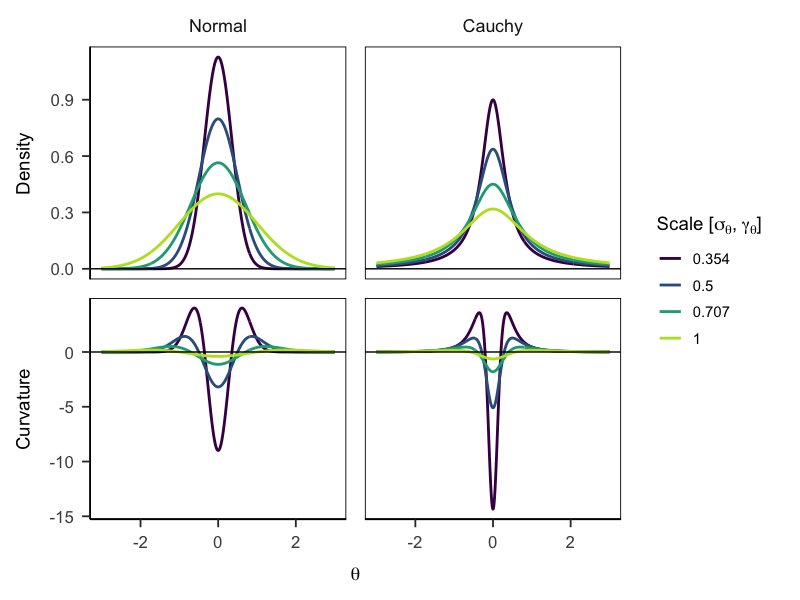

In [ ]:
#| label: fig-curvature-prior
#| fig-cap: Curvature of prior distributions as a funciton of $\theta$ for different prior scales.

curvature_data <- tidyr::expand_grid(
  x = seq(-3, 3, 0.01)
  # x = seq(-3, 5, 0.01)
  , data.frame(
    scale = c(sqrt(2)/2 * 0.5, 0.5, sqrt(2)/2, 1) |> round(3)
  )
) |>
  rowwise() |>
  mutate(
    normal_density = dnorm(x, sd = scale)
    , normal_curvature = cnorm(x, scale)
    # , logistic_density = dlogis(x, scale = scale * sqrt(3) / pi)
    # , logistic_curvature = clogis(x, scale * sqrt(3) / pi)
    , cauchy_density = dcauchy(x, scale = scale)
    , cauchy_curvature = ccauchy(x, scale)
  ) |>
  tidyr::pivot_longer(
    cols = matches("density|curvature")
    , names_to = c("dist", "var")
    , values_to = "value"
    , names_sep = "_"
  ) |>
  mutate(
    dist = factor(dist, labels = c("Cauchy", "Normal")) |> #, "Logistic"
      # relevel("Logistic") |>
      relevel("Normal")
  ) |>
  mutate(
    var = factor(var, labels = c("Curvature", "Density")) |>
      relevel("Density")
  )

commone_elements <- list(
  geom_hline(yintercept = 0, color = "black")
  , scale_color_viridis_d(end = 0.9)
  , labs(x = bquote(theta), color = bquote("Scale ["*sigma[theta]*", "*gamma[theta]*"]"))
  , facet_grid(. ~ dist, )
  , papaja::theme_apa(base_size = 14, box = TRUE)
)

density_plot <- curvature_data |>
  filter(var == "Density") |>
  ggplot(aes(x = x)) +
    geom_line(aes(y = value, color = factor(scale), group = factor(scale)), linewidth = 1) +
    labs(y = "Density") +
    commone_elements

curvature_plot <- curvature_data |>
  filter(var == "Curvature") |>
  ggplot(aes(x = x)) +
    geom_line(aes(y = value, color = factor(scale), group = factor(scale)), linewidth = 1) +
    labs(y = "Curvature") +
    commone_elements +
    theme(
      strip.text.x = element_blank()
    )

density_plot / curvature_plot + 
  plot_layout(ncol = 1, heights = c(1, 0.95), guides = "collect", axes = "collect")

As a rule of thumb, these assumptions are likely to hold in large samples, or for normally distributed $\hat\theta$ if the prior distribution is relatively wide, uninformed and places non-neglibile mass near $\hat\theta$.
In light of this, it is remarkable how well JAB approximates the Bayes factor in practice, @fig-jab-jzs and @fig-jab-prop.
Nonetheless, these assumptions imply that JAB is most accurate with objective uninformed prior distributions unless the sample size is large.

When $W$ is calculated from $p$ values (@eq-w-p), it is further assumed that the $p$ was not corrected for multiple comparisons and was derived from a sampling distribution for a constant sample size, see @sec-desirable-properties.
In practice the latter can usually be taken for granted.
With these boundary conditions made clear, we now show how JAB offers a prinicipled evidential interpretation of $p$ values.

**TODO: Is there an additional assumption about nusance parameters being uncorrelated with test parameter?** 


# The evidential value of $p$

Despite repeated efforts to explain that the $p$ value is not a measure of evidence, proposals to treat it as such continue to be made [p. 117, Bland, 2015; p. 157, Wasserman, 2004; Muff, Nilsen, O'Hara & Nater, 2021; @Cox2011].
@tbl-evidence-categories lists suggested labels for grades of evidence in favor of $\mathcal{H}_1$ for ranges of $p$ values.
Three things are worth noting.
First, the suggested grades of evidence follow from typical thresholds of $p$-values.
Second, the suggested grades of evidence are asymmetric: $p > .100$ is said to provide "little or no evidence" in favor of $\mathcal{H}_1$; only $p < .100$ is suggested to carry evidential value.
Third, we have shown the magnitude of the evidence must depend on the effective sample size $n_\text{eff}$, but the suggested grades of evidence are independent of sample size.
JAB can be used evaluate these grades of evidence from a Bayesian perspective.

In [ ]:
#| label: evidence-categories
#| tbl-cap: "Categorical interpreations of two-sided $p$ values as evidence against $H_0$ and corresponding approximate Bayes factors."

evidence_grades <- tibble::tibble(
  p1 = c(1, rev(p_boundaries[-c(1, length(p_boundaries))]))
  , p2 = dplyr::lead(p1)
  , maxbf1 = 1/minbf(p1) # exp(1) * p * log(p)
  , maxbf2 = 1/minbf(p2)
) |>
  dplyr::rowwise() |>
  dplyr::mutate(
    # qnorm(p1/2)^2 == qchisq(1 - p1, df = 1)
    llb1 = 1 / exp(-0.5 * qchisq(1 - p1, df = 1))
    , llb2 = 1 / exp(-0.5 * qchisq(1 - p2, df = 1))
    # , jab = 1 / (1 * sqrt(5) * exp(-0.5 * qchisq(1 - p, df = 1)))
    # , jab1 = llb1 / sqrt(8) / sqrt(pi/2)
    # , jab2 = llb2 / sqrt(8) / sqrt(pi/2)
    , jab1 = 1 / (exp(-0.5 * qchisq(1 - p1, df = 1) * (30-1) / 30) * sqrt(30))
    , jab2 = 1 / (exp(-0.5 * qchisq(1 - p2, df = 1) * (30-1) / 30) * sqrt(30))
    , jab12 = 1 / (exp(-0.5 * qchisq(1 - p1, df = 1) * (8-1) / 8) * sqrt(8))
    , jab22 = 1 / (exp(-0.5 * qchisq(1 - p2, df = 1) * (8-1) / 8) * sqrt(8))
    # , lbnor1 = sqrt(exp(1)) * -qnorm(p1/2) * exp(-0.5 * qnorm(p1/2)^2)
    , lbnor1 = llb1 / (sqrt(exp(1)) * -qnorm(p1/2))
    , lbnor1 = ifelse(is.infinite(lbnor1), 1, lbnor1)
    , lbnor2 = llb2 / (sqrt(exp(1)) * -qnorm(p2/2)) # Eq. 16, Wagenmakers (2021)
  ) |>
  dplyr::ungroup() |>
  dplyr::mutate(
    p1 = papaja::apa_p(p1)
    , p2 = papaja::apa_p(p2)
  ) |>
  papaja::apa_num(na_string = "") |>
  dplyr::mutate(
    p = paste0(
      "$"
      , ifelse(p1 != "> .999", paste0("(", p1, ", "), "(1.000, ")
      , ifelse(p2 != "", paste0(p2, "]"), ".000)")
      , "$"
    )
    , jab = paste0(
      "$"
      , ifelse(jab1 != "", paste0("(", jab1, ", "), "(0.000, ")
      , ifelse(jab2 != "", paste0(jab2, "]"), "\\infty)")
      , "$"
    )
    , jab2 = paste0(
      "$"
      , ifelse(jab12 != "", paste0("(", jab12, ", "), "(0.000, ")
      , ifelse(jab22 != "", paste0(jab22, "]"), "\\infty)")
      , "$"
    )
    , maxbf = paste0(
      "$"
      , ifelse(maxbf1 != "", paste0("(", maxbf1, ", "), "(0.000, ")
      , ifelse(maxbf2 != "", paste0(maxbf2, "]"), "\\infty)")
      , "$"
    )
    , lbnor = paste0(
      "$"
      , ifelse(lbnor1 != "", paste0("(", lbnor1, ", "), "(0.000, ")
      , ifelse(lbnor2 != "", paste0(lbnor2, "]"), "\\infty)")
      , "$"
    )
    , llb = paste0(
      "$"
      , ifelse(llb1 != "", paste0("(", llb1, ", "), "(0.000, ")
      , ifelse(llb2 != "", paste0(llb2, "]"), "\\infty)")
      , "$"
    )
  ) |>
  dplyr::select(p, jab, jab2, lbnor, maxbf, llb) |>
  dplyr::mutate(
    "Bland (2015)" = c("Little or no evidence", "Weak evidence", "Evidence", "Strong evidence", "Very strong evidence")
    , "Wasserman (2004)" = c("Little or no evidence", "Weak evidence", "Strong evidence", "Very strong evidence", "")
    # , "Lee \\& Wagenmakers (2013)" = c("Little or no evidence", "Anecdotal evidence", "Moderate evidence", "(Very) strong Evidence", "Very strong or extreme evidence")
  ) |>
  dplyr::select(-jab, -jab2, -lbnor, -maxbf, -llb, jab, jab2, lbnor, llb) |> # , maxbf, llb
  dplyr::rename(
    "$p$" = p
    , "$\\text{JAB}_{10}(n_\\text{eff} = 30)$" = jab
    , "$\\text{JAB}_{10}(n_\\text{eff} = 8)$" = jab2
    , "$\\max(\\mathcal{L}_1 / \\mathcal{L}_0)$" = llb
    , "$\\max(\\text{BF}^{\\mathcal{N}}_{10})$" = lbnor
    # , "$\\text{VS-MPR}_{10}$" = maxbf
  )# |>
  # knitr::kable(align = "clccc")

In [ ]:
#| label: tbl-evidence-categories
#| tbl-cap: "Categorical interpreations of two-sided $p$ values as evidence against $H_0$ and corresponding approximate Bayes factors."

library("gt")
colnames(evidence_grades) <- gsub(
  "$"
  , "$$"
  , colnames(evidence_grades)
  , fixed = TRUE
)
dplyr::mutate(
  evidence_grades
  , across(
    everything()
    , ~ gsub("$", "$$", .x, fixed = TRUE)
  )
) |>
# evidence_grades |>
  gt::gt() |>
  gt::fmt_markdown(columns = everything()) |>
  gt::tab_spanner(
    label = "Grades of evidence"
    , columns = 2:3
  ) |>
  gt::tab_spanner(
    label = "Bayesian evidence"
    , columns = 4:6
  ) |>
  gt::tab_footnote(
    footnote = md("$\\text{JAB}_{10}$ assuming a unit-information prior centered on the test-value $\\theta_0$. $\\max(\\text{BF}^{\\mathcal{N}}_{10})$ is the upper limit on the evidence for $\\mathcal{H}_1$ when the prior distribution is normal [p. 231, @Edwards1963].")
  ) #|>
  # gt::as_latex()

<R HTML widget HTML Widget>

@fig-p-jab A shows how $p$ relates to Bayesian evidence as a function of the effective sample size.
As is clear form @eq-jab, there can be no unique relationship between $p$ and the Bayes factor, as the latter always depends on the prior distribution.
<!-- The figure gives the approximate $\text{JAB}_{10}$ for objective testing, i.e., $A = \sqrt{\pi/2}$ as suggested by Jeffreys (1961, p. 277)[^jab-uip]. -->
The figure gives $\text{JAB}_{10}$ assuming a common prior choice in objective testing, the unit-information prior centered on the test-value $\theta_0$ [p. 8, @Wagenmakers2022],

$$
\text{JAB}_{01} = \sqrt{n_\text{eff}} \; \exp\big[ -0.5 \; (n_\text{eff}-1) / n_\text{eff} ~~ Q_{\chi^2(1)}(1-p) \big].
$$ {#eq-jab-uip}

This prior is sufficiently wide that results for small samples are tenable.
The solid lines represent commonly used grades of Bayesian evidence (Jeffreys, 1961; Lee & Wagenmakers, 2013).
Note that both axes are on log-scale.

Warning messages:
1: The text offset exceeds the curvature in one or more paths. This will result in
displaced letters. Consider reducing the vjust or text size, or use the hjust
parameter to move the string to a different point on the path. 
2: The text offset exceeds the curvature in one or more paths. This will result in
displaced letters. Consider reducing the vjust or text size, or use the hjust
parameter to move the string to a different point on the path. 
3: The text offset exceeds the curvature in one or more paths. This will result in
displaced letters. Consider reducing the vjust or text size, or use the hjust
parameter to move the string to a different point on the path. 


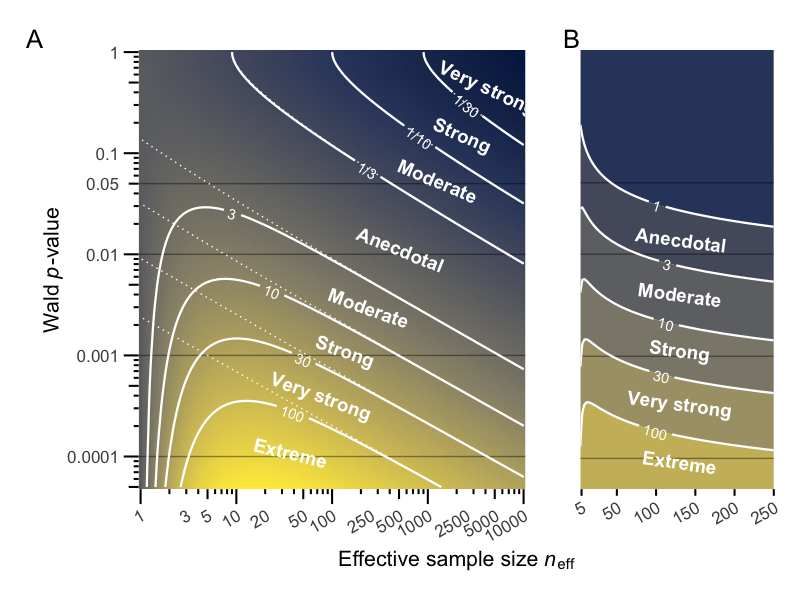

In [ ]:
#| label: fig-p-jab
#| echo: false
#| warning: false
#| fig-cap: Relationship between two-sided $p$-value and $\text{JAB}_{10}$ as a function of effective sample size $n_\text{eff}$. Solid lines represent the $\text{JAB}_{10}$ for a unit-information prior centered on the test-value $\theta_0$. **A** Color represents the continuous evidence with the grades of evidence suggested by Lee & Wagenmakers (2013). The dotted lines represent the $\text{JAB}_{10}$ for a unit-information prior centered on the maximum likelihood estimate $\hat\theta$. **B** Illustration of the shift of the grades of evidence implied by $p$ from small ($n < 50$) to large samples ($n > 250$).

dat <- expand.grid(
  p = exp(seq(log(0.00005), log(1), length.out = 100))
  , n = exp(seq(log(1), log(10000), length.out = 100))
) |>
  dplyr::mutate(
    # jab = 1 / (1 * sqrt(n) * exp(-0.5 * qchisq(1-p, df = 1))) # Exactly identical to bicbf!
    jab = 1 / (sqrt(n) * exp(-0.5 * qchisq(1-p, df = 1) * (n-1)/n))
    , jab_pnpi = 1 / (jab:::jab_pnpi(p, n))
    , jab_3pn = 1 / (jab::jab_3pn(p, n))
    # , jab_3pn = 1 / (jab::jab_3pn(p, n)^((n-1)/n))
    # , jab_pnpi = 1 / (jab:::jab_pnpi(p, n)^((n-1)/n))
    # jab = 1 / (sqrt(pi/2) * sqrt(n) * exp(-0.5 * qchisq(1-p, df = 1)))
    # , jab_3pn = 1 / (sqrt(pi/2) * jab::jab_3pn(p, n))
    # , jab_pnpi = 1 / (sqrt(pi/2) * jab:::jab_pnpi(p, n))
    , bicbf = chi2p_to_bicbf(p, n)
  )

# cum_probs_h0 <- c(p_boundaries[p_boundaries >= 0.05 & p_boundaries < 1], 0.2)
# req_ess <- jab::ess_3pn(3, cum_probs_h0)

plot_settings <- list(
  scale_y_continuous(
    expand = expansion(0, 0)
    , breaks = c(p_boundaries)
    , labels = format(c(p_boundaries), scientific = FALSE, drop0trailing = TRUE)
    , trans = "log"
    , name = bquote("Wald" ~ italic(p) * "-value")
    # , sec.axis = sec_axis(
    #   ~ .
    #   , name = bquote("Cummulative probability under"~italic(H)["0"])
    #   , breaks = cum_probs_h0
    #   , labels = format(1-cum_probs_h0, scientific = FALSE, drop0trailing = TRUE)
    # )
  )
  , theme_minimal(base_size = 16)
  , theme(
    axis.ticks.length = unit(5, "pt")
    , axis.ticks.x = element_line()
    , axis.ticks.y = element_line()
    , plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
    , axis.title.x = element_text(margin = margin(t = 0.1, unit = "cm"))
    , axis.title.y = element_text(margin = margin(r = -0, unit = "cm"))
    , axis.text.x = element_text(angle = 30, hjust = 1)
  )
)

evidence_labels <- tibble::tibble(
  # n = c(17, 45, 75, 150, 350, 800, 1500, 3700)
  # , p = c(0.0002, 0.000475, 0.00125, 0.003, 0.012, 0.055, 0.16, 0.4)
  n = c(32, 67, 120, 210, 450, 1100, 2000, 3700) * 1.15
  , p = exp(log(0.0000002) + 1.75 * log(n))
  , label = c(
    "Extreme", "Very strong", "Strong", "Moderate"
    , "Anecdotal", "Moderate", "Strong", "Very strong"
  )
  , angle = -c(13.5, 20, 20, 20, 22, 23, 24, 25)
)

p1 <- ggplot(dat) +
  aes(x = n, y = p) +
  geom_raster(aes(fill = log(jab)), interpolate = TRUE) +
  # geom_vline(xintercept = 5, alpha = 0.2) +
  geom_hline(yintercept = p_boundaries[1:4], alpha = 0.4) +
  # annotate("segment", x = req_ess, xend = Inf, y = cum_probs_h0, yend = cum_probs_h0, color = "black", linetype = "solid", alpha = 0.2) +
  # annotate("segment", x = req_ess, xend = req_ess, y = cum_probs_h0, yend = min(p_boundaries * 0.5), color = "black", linetype = "solid", alpha = 0.2, arrow = arrow(length = unit(0.15, "inches"))) +
  # geom_contour(
  #   aes(z = jab_3pn)
  #   , color = "white"
  #   , linetype = "dotted"
  #   , breaks = bf_breaks[bf_breaks != 1]
  # ) +
  geom_contour(
    aes(z = bicbf)
    , color = "white"
    , linetype = "dotted"
    , breaks = bf_breaks[bf_breaks != 1]
  ) +
  geom_textcontour(
    aes(z = jab, label = to_reciprocal(after_stat(level)))
    , color = "white"
    , breaks = bf_breaks[!bf_breaks %in% c(1/100, 1)]
    , linewidth = 0.8
  ) +
  geom_text(
    aes(x = n, y = p, label = label, angle = angle)
    , data = evidence_labels
    , color = "white"
    , fontface = "bold"
    , size = 5
    , hjust = 0.5
  ) +
  guides(
    x = guide_axis_logticks()
    , y = guide_axis_logticks()
  ) +
  plot_settings +
  scale_x_continuous(
    expand = expansion(0, 0)
    , breaks = c(1, 3, 5, 10, 20, 50, 100, 250, 500, 1000, 2500, 5000, 10000)
    , trans = "log"
    , name = bquote("Effective sample size" ~ italic(n)["eff"])
  ) +
  scale_fill_viridis_c(guide = "none", option = "E")

dat <- expand.grid(
  p = exp(seq(log(0.00005), log(1), length.out = 100))
  , n = seq(1, 250, length.out = 100)
) |>
  transform(
    # jab = 1 / (sqrt(n) * exp(-0.5 * qchisq(1 - p, df = 1)))
    jab = 1 / (sqrt(n) * exp(-0.5 * qchisq(1 - p, df = 1) * (n - 1) / n))
    , jab_pnpi = 1 / (sqrt(pi / 2) * jab:::jab_pnpi(p, n))
  )

evidence_labels <- tibble::tibble(
  # p = c(0.00008, 0.0003, 0.001, 0.0035, 0.012)
  p = c(0.00008, 0.0003, 0.001, 0.0035, 0.012) * 1.15
  , n = 130 * exp(p)
  , label = c(
    "Extreme", "Very strong", "Strong", "Moderate", "Anecdotal"
  )
  , angle = -7.5
)

p2 <- ggplot(filter(dat, n > 1)) +
  aes(x = n, y = p) +
  stat_contour_filled(
    aes(z = jab, fill = after_stat(level))
    , geom = "polygon"
    , color = NA
    , linetype = "22"
    , breaks = c(1/30, 1.01, 3, 10, 30, 100, Inf)
  ) +
  # geom_raster(aes(fill = log(jab)), interpolate = TRUE) +
  geom_hline(yintercept = p_boundaries[1:4], alpha = 0.4) +
  # geom_contour(
  #   aes(z = jab_pnpi)
  #   , color = "black"
  #   , linetype = "22"
  #   , breaks = c(1, 3, 10, 30, 100)
  # ) +
  geom_textcontour(
    aes(z = jab, label = to_reciprocal(after_stat(level)))
    , color = "white"
    , breaks = c(1, 3, 10, 30, 100)
    , linewidth = 0.8
  ) +
  geom_text(
    aes(label = label, angle = angle)
    , data = evidence_labels[1:5, ]
    , color = "white"
    , fontface = "bold"
    , size = 5
  ) +
   guides(
    y = guide_axis_logticks()
  ) +
  plot_settings +
  scale_x_continuous(
    expand = expansion(0, 0)
    , breaks = c(5, seq(50, 500, 50))
    , name = bquote("Effective sample size" ~ italic(n)["eff"])
  ) +
  scale_fill_viridis_d(guide = "none", option = "E", begin = 0.2, end = 0.8)


p1 + p2 + 
  plot_layout(
    axes = "collect"
    , width = c(2, 1)
  ) + 
  plot_annotation(tag_levels = "A")

Several important consequences for the evidential interpration of $p$ follow.
First, it is clear from @fig-p-jab A that a principled interpretation of $p$-values as continuous measures of evidence must take the effective sample size into account.
The grades of evidence suggested by Bland (2015) approximately correspond to the Bayesian grades of evidence suggested by Lee & Wagenmakers (2013), if the effective sample size is $n_\text{eff} \approx 8$.
This is, however, close to the upper bound on the evidence for this class of prior distribution, $\max(\text{BF}^{\mathcal{N}}_{10})$ [p. 231, @Edwards1963], @tbl-evidence-categories.
As $n_\text{eff}$ increases (or decrease), the suggested grades quickly overstate the Bayesian evidence for $\mathcal{H}_1$.
The grades of evidence suggested by Wasserman (2004) overstate the Bayesian evidence even when $n_\text{eff} \approx 8$---even though @Wasserman2000 agrees with the grades of Bayesian evidence suggested by Lee & Wagenmakers (2013).
For $p < .10$ and $n_\text{eff} > 20$, as the effective sample size increases $\log(p)$ must decreases approximately linearly to yield constant evidence<!--[^approx-linearity]--> (Benjamin et al., XXXX).
Hence, changes in effective sample size noticably affect the evidence in $p$ in small samples, but are less consequential in larger samples, @fig-p-jab B.
Muff, Nilsen, O'Hara and Nater (2021) argue that this deceleration renders sample size irrelevant for the evidential interpretation of $p$ suggested by Bland (2015).
@fig-p-jab B shows this to be incorrect (also see Hartig & Barraquand, 2022).
Assume that typical samples in their field of research are large enough that changing the sample size changes the evidence neglibably, e.g. $n_\text{eff} > 300$.
At this point Bland's grades of evidence overstate the evidence for $\mathcal{H}_1$.
<!-- While in small samples the suggested grades of evidence for $p$ correspond reasonably well to the Bayesian grades of evidence, in large samples they are biased against $\mathcal{H}_0$. -->
For example, in small samples ($n_\text{eff} < 20$) $.01 < p < .001$ usually implies moderate to very strong evidence for $\mathcal{H}_1$, but in larger samples ($n_\text{eff} = 300$) this evidence is strong at best but usually anecdotal or moderate.
In other words, the evidence for $\mathcal{H}_1$ is shifted down relative to Bland's by a full grade.

<!-- [^approx-linearity]: We find that the linear relationship is well approximated by a slight elaboration of this expression, i.e., $\text{JAB}_{01} = p^{9/10} \; \sqrt{n_\text{eff}} \; (\pi - 1)$ and hence $\log(p) = 0.9 \log(\text{JAB}_{01}) - 0.556 \log(n_\text{eff}) - 0.9 \log(\pi - 1)$. -->

Second, given $p$ implies less evidence for $\mathcal{H}_1$ as the effective sample size increases, but in small samples this trend typically reverses.
As shown in @fig-p-jab B and highlighted in @fig-p-jab A, when the unit-information prior is centered on the test value $\theta_0$, the evidence for $\mathcal{H}_1$ implied by $p$ levels off and decreases as the effective sample size becomes very small, $n_\text{eff} < 8$.
However, as shown by the dotted curves in @fig-p-jab A, when the prior is centered on the maximum likelihood estimate $\hat\theta$, the evidence for $\mathcal{H}_1$ continous to increase with the effective sample size.
The difference is most prominent in small samples.
The same prior underlies another popular approximation to the Bayes factor, the $\text{BIC}$.
Again, this prior distribution amounts to using the data twice and is best considered a lower bound on the Bayes factor for the unit-information prior, in particular in small samples $n_\text{eff} < 30$ (Held & Ott, 2018).

A third important consequence that evident from @fig-p-jab A pertains to the evidence implied by $p > 0.1$.
In line with Bland (2015) and Wasserman (2004), in very small samples ($n_\text{eff} < `r 3^2`$) such results provides little or no evidence for either $\mathcal{H}_1$ or $\mathcal{H}_0$.
However, this is not true in general.
In moderate ($`r 3^2` < n_\text{eff} < `r 10^2`$) and large samples ($`r 10^2` < n_\text{eff} < `r 30^2`$) it is possible to obtain moderate to strong evidence for $\mathcal{H}_0$!
Hence, in sufficiently large samples $.1 < p < 1 $ can be informative and provide meaningful evidence for the absence of an effect.

Lastly, JAB can be used to derive lower and upper bounds on the Bayes factor.
For simplicity, consider a unit-information prior centered on the maximum likelihood estimate $\hat\theta$, i.e., $A = 1$ in @eq-jab.
Note that, while mathematically convenient, a prior distribution centered on $\hat\theta$ amounts to using the data twice (to inform the prior distribution under $\mathcal{H}_1$ and to test this hypothesis) and will bias the evidence in favor of $\mathcal{H}_1$.
It can in itself be considered a lower bound on Bayes factors for the unit-information prior.
The lower bound on this Bayes factor for a given $p$ is reached when $n_\text{eff} = 1$,

$$
\min(\text{JAB}_{01}) = \exp\left[-0.5~\left[Q_{\mathcal{N(0,1)}}(p/2)\right]^2\right].
$$

This is the lower bound on the likelihood ratio [$\max(\mathcal{L}_0 / \mathcal{L}_1)$; p. 228, @Edwards1963; p. 116 @Berger1987], @tbl-evidence-categories.
For a comprehensive review on other lower bounds on the Bayes factor see the comprehensive review by @Held2018.
<!-- As noted by Marsman et al. this approximation assumes a standard normal distribution of the probit-transformed $p$-value und the alternative distribution.
We see here that this assumption holds for a normally distributed test statistic.
For the $t$-test, we show in @sec-appendix-bic that violations of this assumption are tolable for a wide range of $p$ even in moderate sample sizes. -->
Conversely, the upper bound on the evidence for $\mathcal{H}_0$ for a given effective sample size $n_\text{eff}$ is reached when $p \to 1$ and thus 

$$
\max(\text{JAB}_{01}) = \sqrt{n_\text{eff}}.
$$

This simple expression holds regardless of the center of the unit-information prior and is a useful reference point when evaluating claims about the absence of an effect based on a non-significant NHST.
Bounds can similary be derived for other prior distributions.

<!-- It is, however, possible to calculate the upper bound of the evidence for the alternative hypothesis across a wide range of sensible prior distributions (e.g., unimodal and symmetrical around 0; Sellke, Bayarri, & Berger, 2001; Berger & Sellke, 1987), the so-called Vovk-Sellke Maximum $p$-Ratio (MS-VPR),

$$
\text{MS-VPR}_{01} =

\begin{cases}
-e~p~\log(p) & \text{if } & p < 1/e \\
                  1 & \text{if } & \text{otherwise}, \\
\end{cases}
$$

where the $p$-value corresponds to a two-sided alternative hypothesis.
As @tbl-evidence-categories shows, the $\text{MS-VPR}$ broadly corroborates our assessment of the suggested grades of evidence for $p$ based on $\text{JAB}$.
**TODO: How is it possible that JAB can indicate stronger evidence than the maximum implied by MS-VPR?**
**This is because this approximation does not work well in small samples, annurev-statistics, Held & Ott (2018)** -->

<!--
At $n = 1$ $\text{JAB}_{10}$ assuming $A = 1$ reduces to the lower Likelihood ratio bound (Berger & Sellke, 1987; @sec-appendix-bic),
$$
\max(\mathcal{L}_1 / \mathcal{L}_0) = \exp(-0.5 \chi^2(1)).
$$

This roughly corresponds to half of the maximum Bayes factor for any prior distribution symmetrical round 0 (i.e., two spikes; Berger & Sellke, 1987; Sellke, Bayarri, & Berger 2001, Table 3).
The VS-MPR roughly corresponds to the maximum Bayes factor for any symmetrical, unimodal prior distribution centered on 0.
-->
<!--
We can solve this expression for $p$ to determine what $p$-values correspond to which evidence category in the ideal case,

$$
p = \exp(W(- \text{BF} / e)).
$$

where $W$ is the Lambert W function.
As @tbl-asymptotic-min-bf-categories shows, *in the best case* $.037 < p < .008$ provides moderate and $.008 < p < .002$ provides strong evidence in large samples.
This illustrates, that when Muff et al. (2021b) appeal to the large-sample stability the $p$-$\text{BF}$ association, they must assume very large samples and a prior distribution that maximizes the evidence.
-->


<!-- 
Lower bound on the Bayes factor

$$
\min(\text{JAB}_{01}) = A \exp\left[-0.5~Q_{\chi^2(1)}(1-p)\right],
$$

which is

$$
\min(\text{JAB}_{01}) = A \exp\left[-0.5~\left[Q_{\mathcal{N(0,1)}}(p/2)\right]^2\right]
$$

but this is silly because we assume $n_\text{eff} = 1$ and we usually know better.

More interesting:

$$
\begin{aligned}
\max(\text{JAB}_{01}) & = A \sqrt{n_\text{eff}} \\
n_\text{eff} & = (\max(\text{JAB}_{01}) / A)^2
\end{aligned}
$$

-->

# Conclusion

Interpreting $p$ values as a measure of statistical evidence for a hypothesis is suggested in statistics text books (p. 117, Bland, 2015; p. 157, Wasserman, 2004; @Cox2011) and continues to be pervasive in research practice (Gigerenzer, <@Gigerenzer2018>; <@Cohen1994>).
Calls to abandon this practice [e.g., **???**, @Hubbard2008; Royall, 1997; Goodman & Royall, 1988] have had limited success.
We hope our discussion contributes to educating researchers about the limitations of $p$ values, but we realize that education alone is not effective in changing behavior [@Albarracn2024; @Wood2024].
Instead of just asking someone to quit a bad habit, it is sometimes more effective to offer them a better alternative [@Albarracn2024].
But adopting better alternatives is difficult when they add friction and $p$ values are often much easier to calculate than Bayes factors.
So in this paper, we provide a simple formula to transform $p$ values into an approximate measure of evidence requiring only the effective sample size: Jeffreys's approximate Bayes factor [JAB; Jeffreys, 1936; @Wagenmakers2022], @eq-jab.
We have demonstrated that JAB is a surprisingly good approximation to the Bayes factors from objective tests of mean comparisons and proportions across a range of realistic scenarios, @fig-jab-jzs and @fig-jab-prop.
And we have illustrated how the evidence implied by a $p$ value is not constant but depends on the effective sample size, @fig-p-jab.

We believe that JAB and @fig-p-jab can be useful tools for researchers, reviewers, and readers to assess claims of both presence and absence of effects---regardless of whether the data were peaked at during data collection.
And in case @eq-jab-uip still causes too much friction, @Wagenmakers2022 has suggested an even simpler approximation, where $\text{JAB}_{01} \approx 3 p \sqrt{n_\text{eff}}$, if $p \leq .10$ (their Eq. 9).

<!-- 
$$
\text{JAB}_{01} \approx
\begin{cases}
\begin{aligned}
3 & p & \sqrt{n} & \text{if } & p \leq .10 \\
& \sqrt{p} & \sqrt{n} & \text{if } .10 < & p \leq .50 \text{ (simpler)} \\
\frac{4}{3} & p^{2/3} & \sqrt{n} & \text{if } .10 < & p \leq .50 \text{ (more precise)} \\
& p^{1/4} & \sqrt{n} & \text{if } & p > .50
\end{aligned}
\end{cases}
$$
-->

<!-- We have found that a closer, albeit slightly more involved, approximation can be achieved through what we call the $p \sqrt{n}~\pi$-rule:

$$
\text{JAB}_{01} \approx
\begin{cases}
\begin{aligned}
p^{9/10} \sqrt{n} & (\pi-1) & \text{if } & p < 0.1 \\
p^{2/3}~ \sqrt{n} & 4/\pi & \text{if } 0.1 \leq & p < 0.6 \\
p^{1/5}~ \sqrt{n} &       & \text{if } & p \geq 0.6
\end{aligned}
\end{cases}
$$

pnnats-rule

$$
\text{JAB}_{01} \approx
\begin{cases}
\begin{aligned}
p^{9/10} \sqrt{n} &  \phantom{e} \pi \log(2) & \text{if } & p < 0.1 \\
p^{2/3}~ \sqrt{n} &           e  \pi \log(2) & \text{if } 0.1 \leq & p < 0.6 \\
p^{1/5}~ \sqrt{n} &                          & \text{if } & p \geq 0.6
\end{aligned}
\end{cases}
$$ 
-->

<!-- To be clear, the $3 p \sqrt{n}$-rule is an approximation to an approximate Bayes factor.
It is a simple rule of thumb that can be used to quickly gauge the evidence implied by a given $p$ value and sample size.
Using the full JAB formula yields a more precise approximation. -->


<!-- ## Limitation

- We need uncorrected, fixed-n p's (or be able to calculate them from the reported information)
- JAB: Assume that the sampling distribution of the MLE is normal, and that se(θ) ≪ σg, where σg is the scale of the prior distribution g(θ).
  - Won't work for small samples or informed priors?
- It all depends on the prior > Use full JAB approximation (set \sigma = 1, standardized effects) -->

\clearpage

# References

::: {#refs}
:::

\clearpage


# Appendix A {.appendix}

# What is $n_\text{eff}$? {.appendix #sec-appendix-n-eff}

In the main text, we largely glossed over an imporant issue when calculating JAB: What is the effective sample size $n_\text{eff}$ in @eq-jab?
The term $\sqrt{n_\text{eff}}$ is the denominator of the standard error of the maximum likelihood estimate, $\text{SE}(\hat \theta)$---it is a function of sample size and scales the standard deviation of the sampling distribution of the $\hat \theta$.
Hence, the correct definition of $n_\text{eff}$ depends on $\theta$.
@Berger2013 provide a general treatment of effective sample size in the linear model for the BIC but equally applies to JAB.
In the following, we show a simpler derivation for the applications shown in in @fig-jab-jzs and @fig-jab-prop.

## Effective sample size for one-sample $t$-tests {.appendix}

In the case of a one-sample $t$-test, $\hat \theta = \hat \mu$---the sample mean---and the standard error is $\text{SE}(\hat \theta = \hat \mu) = \hat \sigma / \sqrt{n}$.
Here, the effective sample size is simply the number of observations, $n_\text{eff} = n$.
Similarly, in the paired-sample $t$-test, $\hat \theta = \hat \mu_\Delta$---the sample mean of the differences between the paired observations---and the standard error is $\text{SE}(\hat \theta = \hat \mu_\Delta) = \hat \sigma_\Delta / \sqrt{n_\Delta}$.
Now, the effective sample size is the number of differences or, equivalently, the number of pairs, $n_\text{eff} = n_\Delta$.
In the independent sample $t$-test, $\hat \theta = \hat \mu_1 - \hat \mu_2 = \Delta \hat \mu$---the difference between the sample means---and, assuming homogeneous variances, the standard error is based on pooled estimate of the standard deviation.
In this case, the effective sample size is half the harmonic mean $H$ of the sample sizes,

$$
n_\text{eff} = H(n_1, n_2) / 2 = (n_2~n_1) / (n_1 + n_2),
$$

an average dominated by the smaller sample size.
In balanced designs, where $n_1 = n_2$, this expression simplifies to $n_\text{eff} = (n_1 + n_2) / 4$, the arithmetic mean.
For the interested reader, we provide the equations for the effective sample size in the more general case of unequal variances---Welch's $t$-test---and the tests of independent proportions in below.
To summarize, the $n_\text{eff}$ in JAB is the factor that scales the standard error of $\hat \theta$ and is a *function* of sample size.
$n_\text{eff}$ is calculated differently for each model and parameterization.
Determining the correct $n_\text{eff}$ can be difficult in more complex models, which is why

## Effective sample size for independent-sample $t$-tests {.appendix}

In the independent sample $t$-test, $\hat \theta = \hat \mu_1 - \hat \mu_2 = \Delta \hat \mu$---the difference between the sample means---and the standard error is

$$
\begin{aligned}
\text{SE}(\hat \theta = \Delta \hat \mu) & = \hat \sigma_p \cdot \sqrt{1/n_1 + 1/n_2} \\
& = \hat \sigma_p \cdot \sqrt{(n_1 + n_2) / (n_1 \cdot n_2)} \\
& = \frac{ \hat \sigma_p }{ \sqrt{(n_1 \cdot n_2) / (n_1 + n_2)}},
\end{aligned}
$$

where $\hat \sigma_p$ is the pooled estiamte of the standard deviation, i.e. the assumedly *common* standard deviation estimated using the data from both samples.
So here, the effective sample size $n_\text{eff}$ is half the harmonic mean of the two sample sizes,

$$
n_\text{eff} = 0.5 \cdot H(n_1, n_2) = (n_1 \cdot n_2) / (n_1 + n_2),
$$

an average dominated by the smaller sample size.
When the variance are unequal, and Welch's $t$-test is reported, the standard error is based on separate estimates of the standard deviation,

$$
\text{SE}(\hat \theta = \Delta \hat \mu) = \sqrt{\hat \sigma_1^2 / n_1 + \hat \sigma_2^2 / n_2}.
$$

To obtain the effective sample size in the above form, we define a variance ratio $w = s^2_1/s^2_2$, which yields

$$
\begin{aligned}
\text{SE}(\hat \theta = \Delta \hat \mu) & = \hat \sigma_1 \cdot \sqrt{1 / n_1 + w / n_2} \\
& = \hat \sigma_1 \cdot \sqrt{(n_1 + wn_2) / (n_1 \cdot n_2)} \\
& = \frac{ \hat \sigma_1 }{ \sqrt{(n_1 \cdot n_2) / (n_1 + wn_2)}}.
\end{aligned}
$$

Hence, $n_\text{eff} = (n_1 \cdot n_2) / (n_1 + wn_2)$, which is half of harmonic mean of the sample sizes weighted by the variance ratio $w$.

See @Berger2013 for more general derivation of the effective sample size in the linear model.

## Effective sample size for two independent proportions {.appendix}

For the test of log odds ratio the standard error can be calculated from the cell frequencies as,

$$
\text{SE}(\hat{\theta} = \log{\text{OR}}) = \sqrt{\frac{1}{y_1 + 0.5} + \frac{1}{y_2 + 0.5} + \frac{1}{n_1 - y_1 + 0.5} + \frac{1}{n_2 - y_2 + 0.5}},
$$

(e.g., Anscombe, 1956; Gart, 1966; Haldane, 1956; cf. Agresti, 1999) which implies that the effective sample size for JAB is,

$$
n_\text{eff} = \left(\frac{1}{y_1} + \frac{1}{y_2} + \frac{1}{n_1 - y_1} + \frac{1}{n_2 - y_2}\right)^{-1}.
$$

<!--
For the test in proportion-space, the effective sample size seems to be

$$
n = \frac{1}{((1/(n_1+1) + 1/(n_2+1)) * (y_1 + y_2 + 1)/(n_1 + n_2 + 2) * (1 - (y_1 + y_2 + 1)/(n_1 + n_2 
    + 1)) * \exp(2))},
$$

where this corresponds to the inverse of the standard error, but I have no idea, why need the extra factor of $\exp{2}$.
But if it's not there, the Bayes factor is too large.
-->

For the $\chi^2$-test, the effective sample size can be derived from the formula for the confidence interval of the difference between two proportions [@Beal1987],

$$
n_\text{eff} = \left[\frac{\hat{\pi}_1(1-\hat{\pi}_1)}{n_1} + \frac{\hat{\pi}_2(1-\hat{\pi}_2)}{n_2}\right]^{-1}.
$$


# Appendix B {.appendix}

# $p$-based JAB for independent and dependent sample $t$-tests {.appendix #sec-appendix-llr}

In @eq-jab, $W$ is used to approximate the likelihood ratio [Wilk's theorem, @Wilks1938], i.e., as $n \to \infty$

$$
\begin{aligned}
W + o_p(1) & = -2 \log(\mathcal{L}_{0} / \mathcal{L}_{1}) \text{, so that} \\
\exp(-0.5 W) + o_p(1) & = \mathcal{L}_{0} / \mathcal{L}_{1}.
\end{aligned}
$$

@eq-w-p shows that the Wald statistic $W$ can be calculated from it's corresponding $p$-value.
However, the $p$-values shown in @fig-jab-jzs based on $t$-values with varying degrees of freedom.
When we use these $p$-values to calculate JAB, we deviate from the original derivation of JAB in two ways: (1) The underlying $t$-statistic is based on a standard error that relies on the unbiased estimate of the population variance (Bessel's correction, $n - 1$).
The Wald statistic, however, is based on the uncorrected maximum likelihood estimate of the variance.
(2) The $p$-value is based on the $t$-distribution rather than the standard normal distribution.
@fig-jabp-jzs illustrates the consequences of these deviations.
JAB overstates the evidence for $\mathcal{H}_1$ when $n_\text{eff}$ is small.
Note, however, that in the data used here the bias exceedes a factor of 3 only in very small samples.
We thus believe, in most situations, the $p$-based JAB is a fair approximation to the JZS-Bayes factor for $t$-tests.
To quote Jeffreys (1961), another influential Bayesian statistician, on the precision of Bayes factors:

> it will seldom matter appreciably to further procedure if \[the Bayes factor\] is wrong by as much as a factor of 3. (p. 433)

Coordinate system already present. Adding new coordinate
system, which will replace the existing one.


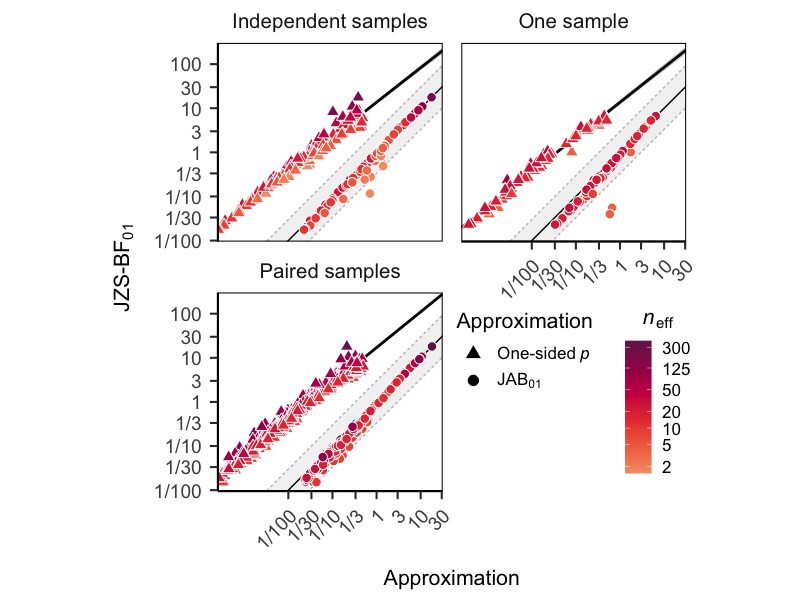

In [ ]:
#| label: fig-jabp-jzs
#| fig-cap:
#|   value: glue::glue("Linear relationships between analytic JZS-Bayes factors for point null hypotheses and $p$-value-based JAB for <<nrow(p_data)>> $t$-test results collected by Aczel et al. (2018) and Wetzels et al. (2011). Triangles represent the logarithm of the one-sided $p$-values, circles represent the logarithm of $\\text{JAB}_{01}$. The color of points indicates the effective sample size. The thick solid black line shows the estimated linear relationship between the one-sided $p$ values and the JZS-Bayes factor. The grey area shows the margin of error of a factor of 3 (p. 433, Jeffreys, 1961).", .open = "<<", .close = ">>")
#|   tag: '!expr'

p <- p_data |>
  ggplot() +
    aes(y = bf01) +
    geom_smooth(aes(x = pos), formula = "y ~ x", method = "lm", fullrange = TRUE, color = "black") +
    geom_abline(slope = 1, intercept = log(1/3), linetype = "22", color = grey(0.75)) +
    geom_abline(slope = 1, intercept = log(3), linetype = "22", color = grey(0.75)) +
    geom_abline(slope = 1, intercept = 0) +
    geom_point(aes(x = pos, fill = neff, shape = "p"), color = "white", size = 3) +
    geom_point(aes(x = jab, fill = neff, shape = "jab"), color = "white", size = 3) +
    scale_shape_manual(values = c(21, 24), labels = c(bquote("JAB"["01"]), bquote("One-sided"~italic(p))), name = "Approximation", guide = guide_legend(override.aes = list(fill = "black", size = 4), reverse = TRUE)) +
    scale_fill_viridis_c(option = "F", begin = 0.3, end = 0.8, direction = -1, trans = "log", breaks = c(2, 5, 10, 20, 50, 125, 300), name = bquote(italic(n)["eff"])) +
    scale_x_continuous(
      trans = "log"
      , breaks = bf_breaks
      , labels = bf_labels
    ) +
    scale_y_continuous(
      trans = "log"
      , breaks = bf_breaks
      , labels = bf_labels
    ) +
    coord_fixed(ratio = 1) +
    labs(x = "Approximation", y = bquote("JZS-"*BF["01"])) +
    facet_wrap(~ type, ncol = 2) +
    papaja::theme_apa(base_size = 16, box = TRUE) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1)
      , legend.box = "horizontal"
      , legend.title = element_text(hjust = 0.5)
      , legend.margin = margin(0, 4, 0, 4)
    )

# Extract panel limits for each facet
plot_build <- ggplot_build(p)

# Extract limits per panel
panel_limits <- lapply(plot_build$layout$panel_params, function(panel) {
  list(
    xlim = panel$x.range
    , ylim = panel$y.range
  )
})

# Combine polygon data for each facet panel
polygon_data <- do.call(rbind, lapply(seq_along(panel_limits), function(i) {
  lims <- panel_limits[[i]]
  xlim <- lims$xlim
  ylim <- lims$ylim
  
  data.frame(
    x = c(ylim[1] - log(3), xlim[2], xlim[2], ylim[1] + log(3)),
    y = c(ylim[1], xlim[2] + log(3), xlim[2] - log(3), ylim[1]),
    group = LETTERS[i],
    panel_id = i  # useful for debugging, optional
  )
}))

# Insert polygon as the first layer
p$layers <- append(
  list(
    geom_polygon(data = polygon_data, aes(exp(x), exp(y), group = group), fill = grey(0.95))
  )
  , p$layers
)

p <- p + 
  coord_fixed(ratio = 1, expand = FALSE) # Keeps panel limits unchanged

p |>
    lemon::reposition_legend(
      position = "center"
      , panel = "panel-2-2"
    )

The results shown in @fig-jabp-jzs rely on the exact likelihood ratio, which can be calculated from the $t$-value [Kendall & Stuart, 1961; @Murtaugh2014; @Francis2022; @Francis2016],

$$
\log(\mathcal{L}_{1} / \mathcal{L}_{0}) = \frac{N}{2}\log\bigg(1 + \frac{t^2}{N - k}\bigg),
$$

where $N$ is the total sample size and $k$ is the number of samples.
The term $N - k$ represents the residual degrees of freedom, which serve as Bessel's correction for the unbiased estimate of the population variance.
As noted above, this is necessary because the likelihood ratio is based on the uncorrected maximum likelihood estimate of the variance.
We have found that the likelihood ratio approximation based on $p$ can yield even better results if the approximate $W$ is adjusted by a corrective factor of $(N / (N - k))$, where $N$ is the total sample size and $k$ is the number of samples:

$$
\begin{aligned}
W_t & = \left[Q_{\mathcal{N(0,1)}}(p_t/2)\right]^2 \\
   & \approx \frac{(\hat \theta - \theta_0)^2}{\sum{(\theta_i - \theta_0)^2} / [(N - k) \; n_\text{eff}]} \\ \\
W & \approx W_t \frac{N}{N - k} \\
  & \approx \frac{(\hat \theta - \theta_0)^2}{\sum{(\theta_i - \theta_0)^2} / [N \; n_\text{eff}]},
\end{aligned}
$$

and

$$
\text{JAB}_{01} \approx A \; \sqrt{n_\text{eff}} \; \exp\left(-0.5 W_t\right)^{N/(N - k)}.
$$

The correction yields a $t$ statistic calculated from the maximum likelihood estimate of the variance.
This statistic is known to follow a location-scale $t$ distribution with $t(\mu = 0, \tau^2 = N / (N - k), \nu = N - k)$.
Knowing that $t(\nu = n - 1) \xrightarrow[]{D} \mathcal{N}(\mu = 0, \sigma^2 = 1)$ as $n \to \infty$, we see that the location-scale $t$ distribution, too, converges to the standard normal distribution as the sample size increases.
@fig-bf-t-z shows the bias in JAB for a one-sample $t$-test when $W$ approximated from $p$, with and without the correction, relative to the analytic likelihood ratio.
Both approximations work well even in relatively small samples---$n > 10$ and $n > 5$, respectively---and in particular for $p > .05$.

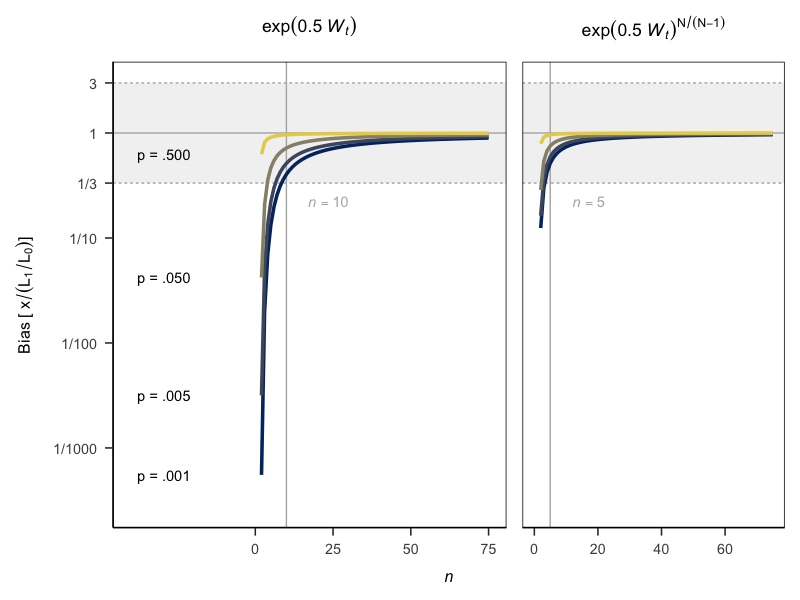

In [ ]:
#| label: fig-bf-t-z
#| fig-cap: Bias of likelihood ratio approximations from $p$ of a one-sample $t$-test ($W_t$; left panel) and with additional correction ($N / (N - 1)$; right panel). The grey area shows the margin of error of a factor of 3 (p. 433, Jeffreys, 1961).
#| warning: false

deflation <- expand.grid(
  p = c(0.5, 0.05, 0.005, 0.001)
  , n = seq(2, 75, by = 1)
) |>
  dplyr::mutate(
    t = qt(p/2, df = n - 1)
    , llr = n/2 * log(1 + t^2 / (n - 1)) # Stuart & Kendal (1961, p225)
    , llr_approx = qchisq(1 - p, df = 1) # qnorm(p/2)^2
    , llr_approx_cor = llr_approx
    , jab = exp(0.5 * (2 * llr))
    , jabp = exp(0.5 * llr_approx)
    , jabp_cor = exp(0.5 * llr_approx_cor)^(n / (n - 1))
  )
  #  dplyr::filter(jab/bic < 1/3) |> dplyr::pull(n)
  # tidyr::pivot_longer(bic:jab, names_to = "method", values_to = "bf") |>

common_elements <- list(
  geom_hline(yintercept = 1, color = grey(0.7))
  , geom_hline(yintercept = c(3, 1/3), linetype = "22", color = grey(0.7))
  , geom_line(linewidth = 1.25)
  , scale_y_continuous(trans = "log", breaks = c(1/1000, 1/100, 1/10, 1/3, 1, 3, 10), labels = MASS::fractions, limits = range(c(deflation$jabp/deflation$jab, 3)) * c(1/2, 1))
  , scale_color_viridis_c(option = "E", trans = "log", begin = 0.1, end = 0.9)
  , guides(color = "none")
  , labs(
    x = bquote(italic(n))
    , y = bquote("Bias ["~x / (L[1]/L[0]) * "]")
    , color = bquote("JAB"["10"])
  )
  , papaja::theme_apa()
)

p1 <- ggplot(deflation) +
  aes(x = n, y = jabp/jab, color = p, group = p) +
  geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = 1/3, ymax = 3), fill = grey(0.95), color = FALSE) +
  geom_vline(xintercept = 10, color = grey(0.7)) +
  annotate("text", x = 17, y = 1/4, label = deparse(bquote(italic(n) == 10)), color = grey(0.7), hjust = 0, vjust = 1, parse = TRUE) +
  common_elements +
  geom_text(aes(x = n - 40, y = jabp/jab, label = paste0("p = ", papaja::apa_p(p))), color = "black", hjust = 0, vjust = 0.5, data = dplyr::filter(deflation, n == 2)) +
  scale_x_continuous(breaks = \(x) {b = scales::extended_breaks()(x); b[b >= 0]}, limits = c(-40, 75)) +
  ggtitle(bquote(exp(0.5 ~ italic(W["t"]))))

p2 <- ggplot(deflation) +
  aes(x = n, y = jabp_cor/jab, color = p, group = p) +
  geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = 1/3, ymax = 3), fill = grey(0.95), color = FALSE) +
  geom_vline(xintercept = 5, color = grey(0.7)) +
  annotate("text", x = 12, y = 1/4, label = deparse(bquote(italic(n) == 5)), color = grey(0.7), hjust = 0, vjust = 1, parse = TRUE) +
  common_elements +
  # geom_text(aes(x = n - 40, y = jabp_cor/jab, label = paste0("p = ", papaja::apa_p(p))), color = "black", hjust = 0, vjust = 0, data = dplyr::filter(deflation, n == 2)) +
  scale_x_continuous(breaks = \(x) {b = scales::extended_breaks()(x); b[b >= 0]}, limits = c(0, 75)) +
  ggtitle(bquote(exp(0.5 ~ italic(W["t"]))^{N/(N-1)}))

p1 + p2 + 
  plot_layout(axes = "collect", widths = c(1, 2/3)) & # guides = "collect", 
  theme(panel.border = element_rect(colour = "black", fill = NA))

When used to calculate JAB, the corrective factor should also be applied to the standard error,

$$
\text{SE}(\hat \theta) \approx \sqrt{[\text{SE}_t(\hat \theta)]^2 \frac{N}{N - k}}.
$$

<!-- Wagenmakers (2021, pp. 19--20) points out that the Bayes factors assuming a unit-information prior and a JZS-prior asymptotically approach a constant ratio of $0.5~\sqrt{\pi}$.
Applying this asymptotic correction to JAB yields an even closes approximation of the JZS-Bayes factor. -->

<!-- 
## Comparison of $3 p \sqrt{n}$-rule to $\text{BIC}$ {.appendix #sec-appendix-bic}


The [3pn rule](3pn-rule.md) is an approximation to an approximate Bayes factor.
The BIC is a similar, widely used approximation that is not limited to testing a single parameter.
Both assume a [unit-information-prior](unit-information-prior.md) [[@wagenmakers2021]].
To compare them, we can convert $t$ (or $p$) and $n$ to the likelihood ratio and the $\text{BIC}$.

We can use the likelihood ratio to calculate the BIC difference using the effective sample size $n_\text{eff}$,

$$
\Delta\text{BIC} = 2 \log(\mathcal{L}_{1}) - \log(\mathcal{L}_{0}) - k \log(n_\text{eff}),
$$

where $k$ is the number of parameters in the model. For the $t$-tests, $k = 1$.
We can then transform the BIC to the Bayes factor according to the formula $\text{BF}_{01} = \exp(\Delta\text{BIC}/2)$.
@fig-3pn-bic-ttest shows the close relationship between JAB and the BIC-Bayes factor for the $t$-tests.
Discrepencies occur only for very small effective sample sizes, where the BIC-Bayes factor indicates stronger evidence for the alternative hypothesis.



**BIC uses a slightly different unit-information prior, i.e., centered on $\hat\theta$ (e.g., https://doi.org/10.1177/0049124103262065).**

A comparison between JAB and BIC must adjust the effective sample size in the calculation of the standard error of the wald statistic (Eq. 5, Wagenmakers, 2021) or, equivalently, in the likelihood of the BIC to obtain the same prior centered on 0.
